**Table of contents**<a id='toc0_'></a>    
- [Visibility](#toc1_)    
  - [I. Usability elements](#toc1_1_)    
    - [I.1 Angle classes](#toc1_1_1_)    
    - [I.2 Interpolation](#toc1_1_2_)    
  - [II. Time](#toc1_2_)    
    - [II.1 Time correction](#toc1_2_1_)    
    - [II.2 Classes for time and date](#toc1_2_2_)    
    - [II.3 Sidereal Time](#toc1_2_3_)    
      - [II.3.1 Sidereal Time at Greenwich](#toc1_2_3_1_)    
      - [II.3.2 LST](#toc1_2_3_2_)    
  - [III. Trajectory along the sky](#toc1_3_)    
    - [III.1 Coordinates](#toc1_3_1_)    
    - [III.2 Compute trajectory](#toc1_3_2_)    
      - [III.2.1 Precession](#toc1_3_2_1_)    
      - [III.2.2 Refraction](#toc1_3_2_2_)    
      - [III.2.3 Star Class Object](#toc1_3_2_3_)    
      - [III.2.4 Motion along the sky](#toc1_3_2_4_)    
      - [III.2.5 Transit, rising and setting](#toc1_3_2_5_)    
  - [IV. Sun](#toc1_4_)    
    - [IV.I Aberration correction](#toc1_4_1_)    
  - [V Moon](#toc1_5_)    
  - [VI Studying the visibility](#toc1_6_)    
    - [VI.I Angular separation](#toc1_6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Visibility](#toc0_)

## <a id='toc1_1_'></a>[I. Usability elements](#toc0_)

Importing required packages and defining functions to extract data from data files in `/data/`. 

In [129]:
## required packages
import os.path as ph
from os import getcwd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# collecting paths of directories
PROJECT_FOLDER = ph.split(getcwd())[0]
DATA_FOLDER = ph.join(PROJECT_FOLDER,'data')


In [130]:
def get_data(filename: str, unpack: bool = True, delimiter: str = ',', message: bool = False) -> np.ndarray:
    """Extracting data from `.csv` or `.txt` files.

    Function takes the name of a data file in `/data` directory and extracts data.

    :param filename: name of the data filter
    :type filename: str
    :param unpack: parameter of `np.loadtxt()`, defaults to `True`
    :type unpack: bool, optional
    :param delimiter: only for `.csv` files, the delimiter between data, defaults to `','`
    :type delimiter: str, optional
    :param message: control parameter, if it is `True` update message will be printed, defaults to `False`
    :type message: bool, optional
    :raises Exception: only `.txt` and `.csv` files are allowed
    
    :return: extracted data
    :rtype: np.ndarray
    """
    # file path
    DATA_FILE = ph.join(DATA_FOLDER,filename)
    if message:
        print('> Open file: ' + DATA_FILE)
    # getting extension of the file 
    ext = filename[-3:]
    if ext == 'csv':
        from pandas import read_csv
        data = read_csv(DATA_FILE, delimiter=delimiter).to_numpy().transpose()
    elif ext == 'txt':
        data = np.loadtxt(DATA_FILE,unpack=unpack)
    else: raise Exception(f'.{ext} is not allowed!\nOnly .txt or .csv files')
    return data

def import_data(filename: str, sel: int | np.ndarray | slice = slice(None), delimiter: str =',', sep: str = ':') -> tuple[np.ndarray]:
    """Extracting target data.

    Functions extracts data for target object(s) as name (`names`), right ascension (`ras`), 
    declination (`decs`) and proper motion (`muas`, `muds`).

    For multiple objects it is possible to select just some, for which data are extracted, 
    through `sel` parameter.

    The standard format for angles (times) is a string:
    `'degrees:primes:seconds.seconds'` (`'hh:mm:ss.ss'`)

      The parameter `sep` is the character separates different units (in this case `':'`) 

    :param filename: name of the data file
    :type filename: str
    :param sel: parameter to select object for which data are extracted, defaults to `slice(None)`
    :type sel: int | np.ndarray | slice, optional
    :param delimiter: only for `.csv` files, the delimiter between data, defaults to `','`
    :type delimiter: str, optional
    :param sep: character to separate different unit, defaults to `':'`
    :type sep: str, optional
    
    :return: extracted data
    :rtype: tuple[np.ndarray]
    """
    # extracting data
    names, ras, decs, muas, muds = get_data(filename,delimiter=delimiter)
    # defining an empty list for proper motion data
    prmts = []
    for i in range(len(names)):
        alpha = ras[i]
        delta = decs[i]
        mua = muas[i]
        mud = muds[i]

        ras[i] = [alpha[0],[float(val) for val in alpha[1:].split(sep)]]
        decs[i] = [delta[0],[float(val) for val in delta[1:].split(sep)]]
        
        mua = float(mua) if mua != 'None' else None
        mud = float(mud) if mud != 'None' else None
        prmts += [[mua,mud]]
    
    return names[sel], ras[sel], decs[sel], prmts[sel]


### <a id='toc1_1_1_'></a>[I.1 Angle classes](#toc0_)

To handle the different units in which one can express the value of an angle on celestial sphere (radiants, degrees, hours), two classes of object are defined: `Angles` and `HAngles`. These keep the value of an angle in different units and provide some useful functions and method to manipulate angles. 

Angle values in degrees or in hours are stored as float type. However, it is possible to pass a _list angle_, that is a list made by a string and a 3d array: the first is the sign, the second stores the values for degrees (hours), primes (minutes) and seconds.

_Example_: $12^{\circ}11'19''$
  * **float angle**: `12.1886` degrees
  * **list angle**: `[ '+', np.array([12,11,19]) ]`

_Example_: $-21h08m31s$
  * **float angle**: `-21.1419` hours
  * **list angle**: `[ '-', np.array([21,8,31]) ]` 

In [131]:
class Angles():
    """Class to handle with angles in degrees or radiants.
    
    The class takes the value of an angle in deg or rad,
    converts one in the other and stored the values.

    The attributes of the class are:

    :ivar rad: the value of the angle in radiants
    :vartype rad: float | None
    :ivar deg: the value of the angle in deg
    :vartype deg: float    
    :ivar lim: the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int

    .. note::
        It is possible to generate a null angle, that is an empty `Angles` object 
        (`self.deg = None` and `self.rad = None`), through the command `Angles(None)`. 
    """

    #: a dictionary to pass from string symbol to integer and vice versa
    strsign = { '+' :  1,
                '-' : -1,
                 1  : '+',
                -1  : '-' }

    @staticmethod
    def decimal(ang: np.ndarray | list) -> float:
        """Function to convert a list angle
        [val, val, val.val] in a float 
        val.val in degrees or hours

        :param ang: angle array value in deg or hms
        :type ang: np.ndarray | list
        
        :return: angle float value
        :rtype: float
        """
        if sum(ang) == 0: return 0
        else: return ang[0] + ang[1]/60 + ang[2]/3600
    
    @staticmethod
    def deg_to_rad(deg: float | np.ndarray) -> float | np.ndarray:
        """Function to convert deg in rad

        :param deg: angle in deg
        :type deg: float | np.ndarray

        :return: value in rad
        :rtype: float | np.ndarray
        """
        # computing radiants
        rad = deg * pi / 180
        return rad

    @staticmethod
    def rad_to_deg(rad: float | np.ndarray) -> float | np.ndarray:
        """Function to convert rad in deg

        :param rad: value in rad
        :type rad: float | np.ndarray
        
        :return: angle in deg
        :rtype: float | np.ndarray
        """
        # computing degrees
        deg = rad * 180 / pi
        return deg

    @staticmethod
    def std_format(deg: float, lim: int) -> list:
        """Function to trasform a float angle in a list angle 

        The wanted format is: [`sign`, [deg (<`lim`), pp (<60), ss.ss (<60)]]

        The value of the angle is in a range set by the `lim` value.
        
        :param deg: float angle
        :type deg: float
        :param lim: limit value
        :type lim: int

        :return: list angle
        :rtype: list
        """
        # storing value of the angle
        ang = deg
        # null angle condition
        if ang == 0.:
            return ['+',np.zeros(3,dtype=int)]
        else:
            # taking the sign as a str
            sign = Angles.strsign[np.sign(ang)]
            # taking the absolute value
            ang = abs(ang)
            # edge condition
            if ang > lim:
                ang %= lim
                # ang -= lim * (ang // lim)
            # degrees
            val = [np.trunc(ang).astype(int)]
            # primes
            val += [np.trunc(ang % 1 * 60).astype(int)]
            # seconds
            val += [round(ang % 1 * 60 % 1 * 60,4)]
            return [sign, np.array(val)]
    
    @staticmethod
    def str_angle(deg: float, rad: float, lim: int, sel: str = 'all', unit: bool = False) -> str:
        """Function to get a string to print the value of an angle
        
        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            * `sel = 'all'`: print value in all units
            * `sel = 'deg'`: print value in deg
            * `sel = 'rad'`: print value in rad

        :param deg: value in deg        
        :type deg: float        
        :param rad: value in rad        
        :type rad: float        
        :param lim: limit value
        :type lim: int
        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        :raises Exception: the only allowed values for `sel` parameter are in this docstring

        :return: the string with the values
        :rtype: str
        """
        # getting list angle fotmat
        deg = Angles.std_format(deg,lim)
        # collecting string for each unit
        dd, mm, ss = deg[1]
        deg_str = deg[0]+f'[{dd:.0f}, {mm:.0f}, {ss:.4f}]'
        rad_str = f'{rad/pi} * pi'
        # condition to print unit names
        if unit:
            deg_str += ' deg'
            rad_str += ' rad'
        # selection condition
        if sel == 'deg': return deg_str
        elif sel == 'rad': return rad_str
        elif sel == 'all': return 'deg =\t' + deg_str + '\nrad =\t' + rad_str
        else: raise Exception(f"-> Error in `sel` parameter!\nsel = {sel} is not allowed\nRead the documentation for correct values of the parameter")

    def __init__(self, ang: float | list | None, unit: str, lim: int = 360) -> None:
        """Constructor of the class

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg and rad. 

        One can pass either a float or a list (see `std_format()` 
        docstring) angle.

        :param ang: angle value
        :type ang: float | list | None
        :param unit: unit of angle value, as `'deg'` or `'rad'`
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to `360`
        :type lim: int, optional
        """
        # setting lim
        self.lim = lim
        # condition for a null angle
        if ang is None:
            self.deg = None
            self.rad = None
        # value in radiants
        elif unit == 'rad':
            self.rad = ang
            self.deg = Angles.rad_to_deg(ang)
        # value in degrees
        elif unit == 'deg':
            # list format condition
            if type(ang) == list:
                # getting the sign
                sign = Angles.strsign[ang[0]]
                # converting in float
                self.deg = Angles.decimal(ang[1])*sign
            else:
                self.deg = ang
            self.rad = Angles.deg_to_rad(self.deg)

    def copy(self):
        """Function to get an exact copy of 
        an `Angles` object

        :return: copy of the angle
        :rtype: Angles
        """
        return Angles(self.deg,'deg',self.lim)

    def print_angle(self, sel: str = 'all', unit: bool = False) -> list[str] | str:
        """Function to print the angle value(s)

        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        
        :return: string (or list of strings) of angle value(s) to print
        :rtype: list[str] | str
        """
        ang = self.copy()
        # condition to generalize the method for not-array type
        if type(ang.deg) != np.ndarray:
            ang.deg = [ang.deg]
            ang.rad = [ang.rad]
        deg = ang.deg
        rad = ang.rad
        # defing the list of strings
        str_list = []
        for i in range(len(deg)):
            str_res = ''
            if sel == 'all' and len(deg) > 1:
                # for array of values printing the index
                str_res += f'ang {i}:\n'
            str_res += Angles.str_angle(deg[i], rad[i], ang.lim, sel=sel, unit=unit)
            str_list += [str_res]
        # only a string for not-array type
        if len(deg) == 1:
            str_list = str_res
        return str_list

    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle or value
        :type angle: Angles | int | float | np.ndarray

        :return: sum of the angles
        :rtype: Angles
        """
        # condition for values
        if isinstance(angle, (int,float,np.ndarray)):
            # converting in `Angles` object
            angle = Angles(angle,'deg',self.lim)
        # checking the edges
        if self.lim != angle.lim:
            print(f'\n!warning: you are summing angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum in rad
        sumrad = self.rad + angle.rad
        return Angles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle or value
        :type angle: Angles | int | float | np.ndarray

        :return: subtraction of the angles
        :rtype: Angles
        """
        # condition for values
        if isinstance(angle, (int,float,np.ndarray)):
            # converting in `Angles` object
            angle = Angles(angle,'deg',self.lim)
        # check for edges
        if self.lim != angle.lim:
            print(f'\n!warning: you are subtracting angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the subtraction in rad
        subrad = self.rad - angle.rad
        return Angles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int | np.ndarray):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: angle-number product
        :rtype: Angles
        """
        return Angles(self.deg*val,'deg',lim=self.lim)
    
    def __truediv__(self, val: float | int | np.ndarray):
        return Angles(self.deg/val,'deg',lim=self.lim)

    def __floordiv__(self, val: float | int | np.ndarray):
        return Angles(self.deg//val,'deg',lim=self.lim)

    def __mod__(self, val: float | int | np.ndarray):
        return Angles(self.deg%val,'deg',lim=self.lim)

    def __rmul__(self,val: float | int | np.ndarray):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: angle-number product
        :rtype: Angles
        """
        return Angles(self.deg*val,'deg',lim=self.lim)
    
    def __rtruediv__(self, val: float | int | np.ndarray):
        return Angles(self.deg/val,'deg',lim=self.lim)

    def __rfloordiv__(self, val: float | int | np.ndarray):
        return Angles(self.deg//val,'deg',lim=self.lim)

    def __rmod__(self, val: float | int | np.ndarray):
        return Angles(self.deg%val,'deg',lim=self.lim)

    def __neg__(self):
        """Function to compute opposite angle

        :return: the opposite angle
        :rtype: Angles
        """
        return self * -1
    
    def __abs__(self):
        return Angles(abs(self.deg),'deg',lim=self.lim)
    
    def __eq__(self, angle) -> bool:
        if not isinstance(angle,(int,float, np.ndarray)):
            angle = angle.deg
        return self.deg == angle

    def __ne__(self, angle) -> bool:
        if not isinstance(angle,(int,float, np.ndarray)):
            angle = angle.deg
        return self.deg != angle

    def __lt__(self, angle) -> bool:
        if not isinstance(angle,(int,float, np.ndarray)):
            angle = angle.deg
        return self.deg < angle

    def __gt__(self, angle) -> bool:
        if not isinstance(angle,(int,float, np.ndarray)):
            angle = angle.deg
        return self.deg > angle

    def __le__(self, angle) -> bool:
        if not isinstance(angle,(int,float, np.ndarray)):
            angle = angle.deg
        return self.deg <= angle

    def __ge__(self, angle) -> bool:
        if not isinstance(angle,(int,float, np.ndarray)):
            angle = angle.deg
        return self.deg >= angle
    



class HAngles(Angles):
    """This is essentially the same class as :class: `Angles`, taking account 
    of the description of an angle in [hours, minutes, seconds] format.

    The attributes are:

    :ivar rad: from :class: `Angles`; the value of the angle in rad 
    :vartype rad: float
    :ivar deg: from :class: `Angles`; the value of the angle in deg 
    :vartype deg: float    
    :ivar deg: the value of the angle in hours
    :vartype deg: float  
    :ivar lim: from :class: `Angles`; the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int

    .. note::
        It is possible to generate a null angle, that is an empty `HAngles` variable
        (`self.deg = None`, `self.rad = None` and `self.hms = None`), through the 
        command `HAngles(None)`. 
    """

    @staticmethod
    def deg_to_hms(deg: float | np.ndarray) -> float | np.ndarray:
        """Function to convert deg in hours

        1 hour = 15 degrees

        :param deg: angle in deg
        :type deg: float | np.ndarray

        :return: angle in hours
        :rtype: float | np.ndarray
        """
        hms = deg / 15
        return hms
    
    @staticmethod
    def hms_to_deg(hms: float | np.ndarray) -> float | np.ndarray:
        """Function to convert hours in deg

        1 hour = 15 degrees

        :param hms: angle in hours
        :type hms: float | np.ndarray

        :return: angle in deg
        :rtype: float | np.ndarray
        """
        deg = hms * 15
        return deg
    
    @staticmethod
    def rad_to_hms(rad: float | np.ndarray) -> float | np.ndarray:
        """Function to convert rad in hours

        It pass through the `rad_to_deg()` and
        `deg_to_hms()` functions

        :param rad: angle value in rad
        :type rad: float | np.ndarray

        :return: angle in hours
        :rtype: float | np.ndarray
        """
        deg = Angles.rad_to_deg(rad)
        hms = HAngles.deg_to_hms(deg)
        return hms
    
    @staticmethod
    def hms_to_rad(hms: float | np.ndarray) -> float | np.ndarray:
        """Function to convert hours in rad

        It pass through the `hms_to_deg()` and
        `deg_to_rad()` functions

        :param rad: angle in hours
        :type rad: float | np.ndarray

        :return: angle value in rad 
        :rtype: float | np.ndarray
        """
        deg = HAngles.hms_to_deg(hms)
        rad = Angles.deg_to_rad(deg)
        return rad

    @staticmethod
    def str_angle(deg: float, rad: float, hms: float, lim: int, sel: str = 'all', unit: bool = False) -> str:
        """Function to get a string to print the value of an angle
        (inherited from :class: `Angles`)

        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            * `sel = 'all'`: print value in all units
            * `sel = 'deg'`: print value in deg
            * `sel = 'rad'`: print value in rad
            * `sel = 'hms'`: print value in hms

        :param deg: value in deg        
        :type deg: float        
        :param rad: value in rad        
        :type rad: float        
        :param hms: value in hours        
        :type hms: float
        :param lim: limit value
        :type lim: int
        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        :raises Exception: the only allowed values for `sel` parameter are in this docstring

        :return: the string with the values
        :rtype: str
        """
        # getting list angle fotmat
        hms = Angles.std_format(hms,lim/15)
        # collecting string for each unit
        hh, mm, ss = hms[1]
        hms_str = hms[0]+f'[{hh:.0f}, {mm:.0f}, {ss:.4f}]'
        # condition to print unit names
        if unit:
            hms_str += ' hms'
        # selection condition
        if sel == 'hms': return hms_str
        elif sel == 'all': return  Angles.str_angle(deg, rad, lim, sel=sel, unit=unit) + '\nhms = \t' + hms_str
        else: return Angles.str_angle(deg, rad, lim, sel=sel, unit=unit)
    
    def __init__(self, ang: float | list | None, unit: str, lim: int = 360):
        """Constructor of the class (inherited from :class: `Angles`)

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg, rad and hours. 

        One can pass either a float or a list (see `std_format()` 
        docstring) angle.

        :param ang: angle value
        :type ang: float | list | None
        :param unit: unit of angle value, like `'deg'`, `'rad'` or `'hms'`
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to `360`
        :type lim: int, optional
        """
        # `Angles.__init__()` function
        super().__init__(ang, unit, lim)
        # condition for a null angle 
        if ang is None:
            self.hms = None
        # angle in hms
        elif unit == 'hms':
            # list format condition
            if type(ang) == list:
                # getting the sign
                sign = Angles.strsign[ang[0]]
                # converting in float
                self.hms = Angles.decimal(ang[1])*sign
            else:
                self.hms = ang
            self.deg = HAngles.hms_to_deg(self.hms)
            self.rad = HAngles.hms_to_rad(self.hms)
        # angle in rad or deg
        else:
            self.hms = HAngles.deg_to_hms(self.deg)

    def copy(self):
        """Function to get an exact copy of 
        an `HAngles` object

        :return: copy of the angle
        :rtype: HAngles
        """
        return HAngles(self.deg,'deg',self.lim)
    
    def print_angle(self, sel: str = 'all', unit: bool = False) -> list[str] | str:
        """Function to print the angle value(s)

        :param sel: to select in which unit printing the angle, defaults to `'all'`
        :type sel: str, optional
        :param unit: if `True` also the unit name is printed, defaults to `False`
        :type unit: bool, optional
        
        :return: string (or list of strings) of angle value(s) to print
        :rtype: list[str] | str
        """
        ang = self.copy()
        # condition to generalize the method for not-array type
        if type(ang.deg) != np.ndarray:
            ang.deg = [ang.deg]
            ang.rad = [ang.rad]
            ang.hms = [ang.hms]
        deg = ang.deg
        rad = ang.rad
        hms = ang.hms
        # defing the list of strings
        str_list = []
        for i in range(len(deg)):
            str_res = ''
            if sel == 'all' and len(deg) > 1:
                # for array of values printing the index
                str_res += f'ang {i}:\n'
            str_res += HAngles.str_angle(deg[i], rad[i], hms[i], ang.lim, sel=sel, unit=unit)
            str_list += [str_res]
        # only a string for not-array type
        if len(deg) == 1:
            str_list = str_res
        return str_list
    
    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle or value
        :type angle: HAngles | Angles | int | float | np.ndarray

        :return: sum of the angles
        :rtype: HAngles
        """
        # condition for values
        if isinstance(angle, (int,float,np.ndarray)):
            # converting in `HAngles` object
            angle = HAngles(angle,'deg',self.lim)
        # checking the edges
        if self.lim != angle.lim:
            print(f'-> Warning: you are summing angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum in rad
        sumrad = self.rad + angle.rad
        return HAngles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle or value
        :type angle: HAngles | Angles | int | float | np.ndarray

        :return: subtraction of the angles
        :rtype: HAngles
        """
        # condition for values
        if isinstance(angle, (int,float,np.ndarray)):
            # converting in `HAngles` object
            angle = HAngles(angle,'deg',self.lim)
        # checking the edges
        if self.lim != angle.lim:
            print(f'-> Warning: you are subtracting angles with different limits: {self.lim} and {angle.lim}!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the subtaction in rad
        subrad = self.rad - angle.rad
        return HAngles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int | np.ndarray):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: angle-number product
        :rtype: HAngles
        """
        return HAngles(self.deg*val,'deg',lim=self.lim)

    def __truediv__(self, val: float | int | np.ndarray):
        return HAngles(self.deg/val,'deg',lim=self.lim)
    
    def __floordiv__(self, val: float | int | np.ndarray):
        return HAngles(self.deg//val,'deg',lim=self.lim)

    def __mod__(self, val: float | int | np.ndarray):
        return HAngles(self.deg%val,'deg',lim=self.lim)

    def __rmul__(self,val: float | int | np.ndarray):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: angle-number product
        :rtype: HAngles
        """
        return HAngles(self.deg*val,'deg',lim=self.lim)

    def __rtruediv__(self, val: float | int | np.ndarray):
        return HAngles(val/self.deg,'deg',lim=self.lim)
    
    def __rfloordiv__(self, val: float | int | np.ndarray):
        return HAngles(val//self.deg,'deg',lim=self.lim)

    def __rmod__(self, val: float | int | np.ndarray):
        return HAngles(val%self.deg,'deg',lim=self.lim)

    def __neg__(self):
        """Function to compute opposite angle

        :return: the opposite angle
        :rtype: HAngles
        """
        return self * -1

    def __abs__(self):
        return HAngles(abs(self.deg),'deg',lim=self.lim)
    
    def __eq__(self, angle) -> bool:
        if isinstance(angle,(Angles,HAngles)):
            angle = angle.deg
        return self.deg == angle

    def __ne__(self, angle) -> bool:
        if isinstance(angle,(Angles,HAngles)):
            angle = angle.deg
        return self.deg != angle

    def __lt__(self, angle) -> bool:
        if isinstance(angle,(Angles,HAngles)):
            angle = angle.deg
        return self.deg < angle

    def __gt__(self, angle) -> bool:
        if isinstance(angle,(Angles,HAngles)):
            angle = angle.deg
        return self.deg > angle

    def __le__(self, angle) -> bool:
        if isinstance(angle,(Angles,HAngles)):
            angle = angle.deg
        return self.deg <= angle

    def __ge__(self, angle) -> bool:
        if isinstance(angle,(Angles,HAngles)):
            angle = angle.deg
        return self.deg >= angle


# defining some fixed angles
RIGHT = Angles( 90.,'deg')
FLAT  = Angles(180.,'deg')
ROUND = Angles(360.,'deg')

### <a id='toc1_1_2_'></a>[I.2 Interpolation](#toc0_)

For some quantities it is necessary to interpolate the value from a data table. In order to do that an interpolation function is implemented: the `interpole_three()` function interpolates value by three data points. This kind of interpolation is possible if the _third difference_ is _"small"_ (less than 3) only. 

Taking four points $y_1, y_2, y_3, y_4$, $D^{'}_{ij}\equiv y_j - y_i$ ($j = i+1$) and $D^{''}_{ijk} \equiv D^{'}_{jk} - D^{'}_{ij}$ ($j=i+1$ and $k=j+1$), the _third difference_ is $D^{'''}_{1234} \equiv D^{''}_{234} - D^{''}_{123} = D^{'}_{34} + D^{'}_{12} - 2D^{'}_{23}$     

In [132]:
def interpole_three(values: list | np.ndarray, centre: float | None = None, xvalues: list | np.ndarray | None = None, val: str | None = None, **kargs) -> float | tuple[float, dict]:
    """Computing interpolated value from three data points.

    If more than three points are passed, function computes third difference(s) in order to 
    check whether interpolation is possible or not.

    It possible to interpolate also extrema or zero points through the parameter `val`:

      * `val = None`: no additional result is returned
      * `val = 'ym'`: the extrema values and the corresponding interpolation parameter are computed
      * `val = 'n0'`: the interpolation parameter for zero point is computed
      * `val = 'all'`: both are computed

    For `val is not None` a dictionary with selected additional values are returned, in addition to the interpolated one. 

    To disable the warning messages one can use the parameter `warning = False` of kargs.

    :param values: y values from which interpolating
    :type values: list | np.ndarray
    :param centre: x value for which interpolating, defaults to `None`
    :type centre: float | None, optional
    :param xvalues: x values corrisponding to y values, defaults to `None`
    :type xvalues: list | np.ndarray | None, optional
    :param val: for additional results, defaults to `None`
    :type val: str | None, optional
    :param kargs: additional parameters
    :type kargs: Any 
    
    :return: the interpolated value and if `val is not None` selected additional results
    :rtype: float | tuple[float, dict]
    """
    # condition for warning messages
    if 'warning' in kargs.keys():
        warning = kargs['warning']
    else:
        warning = True
    
    # storing dimension and values
    dim = len(values)
    sample = np.copy(values)
    # condition for more than three values
    if dim > 3:
        # central value is necessary
        if centre == None: raise Exception('Error in central value!\n You have to pass the central value for interpolation')
        # also x values are necessary
        if len(xvalues) == 0: raise Exception('Error in `xval`!\n You have to pass x values for interpolation')
        # checking the magnitude of the third difference
        diff = np.diff(np.diff(np.diff(sample)))
        maxdiff = diff.max()
        if np.abs(maxdiff) > 3: 
            raise Exception(f'Error in interpolation!\nThe third difference is not negligible: {maxdiff}')
        # finding the index of the x value that is nearest to the `centre`
        idx = (np.abs(xvalues - centre)).argmin()
        # check for edges
        if idx == dim-1: idx -= 1
        elif idx == 0: idx += 1
        # cutting the sample to have only three elements
        # centered in central value
        sample = sample[idx-1:idx+2]
        xvalues = xvalues[idx-1:idx+2]
    # checking at least three values are passed
    elif dim < 3: 
        raise Exception('!Error in length!\nInterpolation needs three points at least')
    # getting the central value
    centre_val = sample[1]
    # computing differences
    a, b = np.diff(sample)
    c = b - a
    # central value is necessary
    if centre != None:
        # getting the x central value
        x2 = xvalues[1]
        # computing the interpolation factor
        n = (centre - x2)/np.abs(x2-xvalues[0])
        # computing the interpolated value
        result = centre_val + n/2 * (a + b + n*c) 
    else:
        if warning: 
            print(': No interpolation was done: parameter `centre` set to `None`')
        result = None

    # condition to compute additional quantities
    if val != None:
        # defining the dictionary for additional values
        dval = {}
        # condition to compute extrema through iterpolation
        if val == 'ym' or val == 'all':
            dval['ym'] = centre_val - (a+b)**2/(8*c)
            dval['nm'] = - (a+b) / (2*c)
        # condition to compute where function is null through iterpolation
        if val == 'n0' or val == 'all':
            # recursive method  
            n0 = 0
            cnt = 0     # control variable
            while True:
                dn0 = -(2*centre_val + n0*(a+b+c*n0))/(a+b+2*c*n0)
                n0 += dn0
                cnt += 1
                # condition to stop the loop
                if np.abs(dn0) < 1e-6:
                    break
                # control condition to prevent a Stack Overflow error
                if cnt > 20 and warning:
                    n0 = None 
                    print('Algorithm did not converge for n0!')
                    break
            dval['n0'] = n0 
        # appending the dictionary to the result
        result = (result, dval)
    return result


## <a id='toc1_2_'></a>[II. Time](#toc0_)


### <a id='toc1_2_1_'></a>[II.1 Time correction](#toc0_)

The difference between Universal Time (UT) and Dynamical Time (TD) need a direct measure. The `/data/dT_data.csv` file contains a table of values of $\Delta T = TD - UT$ for different years. If the year for the wanted $\Delta T$ is in $[1620,1998]$, but not in the table, the corresponding value will be obtained by interpolation. For the other years an empirical formula is used, instead.    

In [133]:
def time_correction(year: float | int, **kargs) -> float:
    """Computing the difference between TD and UT

    For years between 1620 and 1998 the 
    difference is computed through 
    interpolation from a data table (see
    `/data/dT_data.csv`)
    
    For years out that range an 
    approximated formula is used, instead

    :param year: year for which computing TD-UT
    :type year: float | int
    
    :return: TD - UT
    :rtype: float
    """
    # interpolation from data table
    if 1620 <= year <= 1998:
        # name of data file
        filename = 'dT_data.csv'
        # extracting data
        y0, dt0 = get_data(filename)
        # value is already in data
        if year in y0:
            dt = dt0[year == y0][0]
        # computing interpolation
        else:
            dt = interpole_three(dt0,centre=year,xvalues=y0,kargs=kargs)
    # approximated formula
    else:        
        t = (year - 2000)/100
        if year < 948:
            dt = 2177 + 497*t + 44.1*t**2
        else:
            dt =  102 + 102*t + 25.3*t**2
        if 2000 <= year <= 2100: dt += 0.37*(year-2100)
    return dt


### <a id='toc1_2_2_'></a>[II.2 Classes for time and date](#toc0_)

To handle with times and dates two classes are implemented:

  - **Time**
    
      This class stores the value of time in seconds and the information about what kind of time is (UT, TD or local time). 
  
  - **Date**

      In addition to the date and time, the corresponding Julian day is stored in this class. The information about the kind of calendar date is collected, too.
      If the wanted date is a local civil date, the constructor of the class computes date for UT; this operation requires the information about time zone and daylight saving as input. 


In [134]:
class Time():
    """Class to store and manipolate time data

    The class takes value of time in seconds (or in [hh,mm,ss.ss])
    and the name of the kind of time to store them

    The attributes of the class are:

    :ivar val: the value of the angle in radiants
    :vartype val: float | np.ndarray | None
    :ivar tytime: the value of the angle in deg
    :vartype tytime: str    
    """

    #: the number of seconds in a day
    DAYSEC = 86400.

    @staticmethod
    def seconds(hh: int, mm: int, ss: float) -> float:
        """Function to convert time from [hh,mm,ss.ss] to seconds

        :param hh: hours
        :type hh: int
        :param mm: minutes
        :type mm: int
        :param ss: seconds
        :type ss: float
        
        :return: value in seconds only
        :rtype: float
        """
        return ss + mm*60 + hh*3600 
    
    @staticmethod
    def hms_form(time: float) -> list:
        """Function to convert time from seconds to [hh, mm (<60), ss.ss (<60)]

        :param time: value in seconds only
        :type time: float
        
        :return: value in [hh, mm (<60), ss.ss (<60)]
        :rtype: list
        """
        # getting seconds < 60
        # seconds are appoximated 
        ss = np.round(time % 60, 4)
        # getting minutes < 60
        mm = int((time // 60) % 60)
        # getting hours
        hh = int(time // 3600)
        # check
        if ss == 60: 
            ss -= 60
            mm += 1
        if mm == 60:
            mm -= 1
            hh += 1
        return [hh,mm,ss]
    
    @staticmethod
    def str_time(time: float, timetype: str, timezone: int = 0, dl_save: bool = False) -> str:
        """Function to get a string to print time value

        The format of the string is `'hh:mm:ss.ssss [timetype]'`.

        If the time is local civil one the time zone is printed, 
        instead of time type, like `'hh:mm:ss.ssss ([time zone])'`.
        If it is present the information about daylight saving
        is also added: `'hh:mm:ss.ssss ([time zone], dl.)'`

        :param time: value in seconds only
        :type time: float
        :param timetype: kind of time 
        :type timetype: str
        :param timezone: the time zone, defaults to `0`
        :type timezone: int, optional
        :param dl_save: if it is `True` daylight saving is taken into account, defaults to `False`
        :type dl_save: bool, optional
        
        :return: the string with time value and informations
        :rtype: str
        """
        # getting time in [hh,mm,ss.ss] format
        hh,mm,ss = Time.hms_form(time)
        # adding a 0 before the number if it is < 10
        strzero = '0' if hh < 10 else ''
        # starting to built the string
        strtime = strzero + f'{hh}:'
        # adding a 0 before the number if it is < 10
        strzero = '0' if mm < 10 else ''
        # updating the string
        strtime += strzero + f'{mm}:'
        # adding a 0 before the number if it is < 10
        strzero = '0' if ss < 10 else ''
        # defing a method to print decimals of seconds only if they are
        form = lambda x: f'{x:.0f}' if x % 1 == 0 else f'{x:.4f}'
        # updating the string
        strtime += strzero + form(ss)
        # condition for local civil time
        if timezone != 0 or timetype == 'timezone':
            timetype = '('
            if timezone > 0: timetype += '+'
            timetype += f'{timezone}'
            # condition for daylight saving
            if dl_save: timetype += ', dl.s.'
            timetype += ')'
        return strtime + ' ' + timetype

    def __init__(self, value: list | float | np.ndarray | None = None, timetype: str = 'UT') -> None:
        """Constructor of the class

        Function takes a time value in seconds or in [hh,mm,ss.ss] and the kind of time and
        stores them.

        :param value: time value in seconds, defaults to `None`
        :type value: list | float | np.ndarray | None, optional
        :param timetype: kind of time, defaults to `'UT'`
        :type timetype: str, optional
        """
        # for None value returning a zero value
        if value is None: 
            value = 0.0
        # condition for time in [hh,mm,ss.ss]
        elif type(value) == list:
            # converting in seconds only
            value = Time.seconds(*value)
        # condition for array
        elif type(value) == np.ndarray:
            value = np.copy(value)
        self.val = value
        self.tytime = timetype

    def copy(self):
        """Function to make an exact copy of a `Time` object

        :return: the exact copy of the `Time` object
        :rtype: Time
        """
        time = self.val
        timetype = self.tytime
        return Time(time,timetype)
    
    def change_time_type(self, year: int | float | np.ndarray, tytime: str, out: str = 'sec'):
        """Converting UT in TD and vice versa.

        Function calls `time_correction()` function to converting time 
        from `self.tytime` to `tytime`. If they are the same nothing 
        happends.

        It is possible to choose the output of the function:

          * `out = 'sec'`: the computed value in seconds is returned
          * `out = 'Time'`: the computed value is returned as `Time` object

        :param year: year for which time correction is computed 
        :type year: int
        :param tytime: the wanted type of time
        :type tytime: str
        :param out: parameter to choose the output, defaults to `'sec'`
        :type out: str, optional
        
        :return: computed value either in seconds or in `Time` class object
        :rtype: float | np.ndarray | Time

        :raises Exception: only UT and TD are allowed as tipies
        """
        # getting the value
        time = self.copy().val
        # condition to make the correction
        if tytime != self.tytime:
            # computing the time correction
            # condition for array type
            if type(year) == np.ndarray:  
                dt = np.array([time_correction(yy) for yy in year])
            # condition for float
            else:
                dt = time_correction(year)
            # convertion
            if tytime == 'TD':   time += dt
            elif tytime == 'UT': time -= dt
            else: raise Exception('Error in time type!\nConversion is possible only for TD and UT, not for '+tytime)
        # condition for the output
        if out == 'sec':
            return time
        elif out == 'Time':
            return Time(time,timetype=tytime)

    def minute(self) -> float | np.ndarray:
        """Function to get time value in minutes.

        :return: value in minutes
        :rtype: float | np.ndarray
        """
        return self.val / 60

    def hour(self) -> float | np.ndarray:
        """Function to get time value in hours

        :return: value in hours
        :rtype: float | np.ndarray
        """
        return self.val / 3600

    def local_to_ut(self, timezone: int, dl_save: bool):
        """Function to convert local civil time in UT.

        Function takes information about time zone and
        daylight saving as input to return a `Time`
        object of time value in UT.

        :param timezone: time zone value
        :type timezone: int
        :param dl_save: if it is `True` daylight saving is taken into account
        :type dl_save: bool

        :return: time in UT
        :rtype: Time
        """
        hour = self.copy().hour()
        # condition for daylight saving
        if dl_save:
            hour -= 1
        hour -= timezone
        return Time(hour*3600,'UT')

    def print_time(self, enum: bool = True) -> list[str] | str:
        """Function to print time value.

        The parameter `enum` allows to print 
        the index for array values.

        :param enum: parameter for array, defaults to True
        :type enum: bool, optional
        
        :return: string (or list of string) with time value(s)
        :rtype: list[str] | str
        """
        time = self.copy()
        # condition to generalize the method for not-array type
        if type(time.val) != np.ndarray:
            time.val = np.array([time.val])
        sec = time.val
        # defing the list of strings
        str_list = []
        for i in range(len(sec)):
            str_res = ''
            if len(sec) > 1 and enum:
                # for array of values printing the index
                str_res += f'time {i}:\n'
            str_res += Time.str_time(sec[i], time.tytime)
            str_list += [str_res]
        # only a string for not-array type
        if len(sec) == 1:
            str_list = str_res
        return str_list

    def __add__(self, time):
        """Function to sum times

        If the adding value is not a `Time` object,
        it is considered a time in seconds.

        :param time: the value to sum
        :type time: Time | int | float | np.ndarray
        
        :return: the sum
        :rtype: Time
        """
        # condition for not-`Time` object
        if isinstance(time,(float,int,np.ndarray)):
            sumtime = self.val + time
        else:
            sumtime = self.val + time.val
        return Time(sumtime,self.tytime)
    
    def __sub__(self, time):
        """Function to subctraction times

        If the subctracting value is not a `Time` 
        object, it is considered a time in seconds.

        :param time: the value to subtract
        :type time: Time | int | float | np.ndarray
        
        :return: the subtraction
        :rtype: Time
        """
        # condition for not-`Time` object
        if isinstance(time,(float,int,np.ndarray)):
            subtime = self.val - time
        else:
            subtime = self.val - time.val
        return Time(subtime,self.tytime)
              
    def __mul__(self,val: float | int | np.ndarray):
        """Function to implement the time-number product

        :param val: a number
        :type val: float | int | np.ndarray

        :return: time-number product
        :rtype: Time
        """
        time = self.val * val
        return Time(time,timetype=self.tytime)

    def __neg__(self):
        return self * -1

class Date():
    """Class to store and handle dates and times

    Date, time, corresponding Julian day and calendar 
    type are stored in this class object.

    One can pass the Julian day or the date and time to the 
    constructor of the class; for the latter the stored 
    date is not the input value, but the computed one from 
    the corresponding Julian day. This procedure was 
    implemented to avoid possible typing errors in date or 
    time (such as wrong day number for a month, leap years,
    more than 24 hours for time).

    If date and time are local civil ones they are 
    converted in UT.

    The attributes of the class are:

    :ivar jd: Julian day
    :vartype jd: float | np.ndarray
    :ivar date: date value [year, month, day]
    :vartype date: list[int] | list[np.ndarray]
    :ivar time: time value
    :vartype time: Time
    :ivar calendar: calendar type
    :vartype calendar: str    
    """
    #: corresponding julian day for each epoch
    J2000 = 2451545.
    B1950 = 2433282.4235
    B1900 = 2415020.3135

    #: a dictionary to pass from the number of a month to its name
    MONTHS = {
        1 : 'January',
        2 : 'February',
        3 : 'March',
        4 : 'April',
        5 : 'May',
        6 : 'June',
        7 : 'July',
        8 : 'August',
        9 : 'September',
        10 : 'October',
        11 : 'November',
        12 : 'December'
    }

    @staticmethod
    def julian_day(year: int | np.ndarray, month: int | np.ndarray, day: float | int | np.ndarray, time: float | np.ndarray, calendar: str = 'Gregorian', MJD: bool = False) -> float | np.ndarray:
        """Computing the Julian day.

        One can compute the JD from a date of either the Gregorian or Julian calendar 
        and also the Modified JD (MJD) through the parameter `MJD`.


        :param year: year value
        :type year: int | np.ndarray
        :param month: month number
        :type month: int | np.ndarray
        :param day: day value
        :type day: float | int | np.ndarray
        :param time: time value in seconds
        :type time: float | np.ndarray
        :param calendar: calendar type, defaults to `'Gregorian'`
        :type calendar: str, optional
        :param MJD: if `True` the MJD is computed, defaults to `False`
        :type MJD: bool, optional
        
        :return: corresponding Julian day
        :rtype: float | np.ndarray
        
        :raises Exception: only Julian and Gregorian calendar are allowed
        """
        # condition to generalize the method for not-array type
        if type(year) != np.ndarray:
            year = np.array([year])
            month = np.array([month])
            day = np.array([day])
            time = np.array([time])
        
        # checking if there some dates that are
        # previous than 1582 October 15
        tmp = np.where(year < 1582)[0]
        if len(tmp) != 0:
            tmp = np.where(month[tmp] < 10)[0]
            if len(tmp) != 0:
                tmp = np.where(day[tmp] < 15)[0]
        # if there are, indecies are stored
        if len(tmp) != 0: 
            idx = np.delete(np.arange(len(year)),tmp)
        else:
            idx = slice(None)
        del tmp

        # converting time in decimal of day
        day = day.astype(float)
        day += time/Time.DAYSEC
        # condition for month number = 1 or 2
        year  = np.where(month <= 2, year-1, year)
        month = np.where(month <= 2, month+12, month)
        # computing JD
        JD = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day - 1524.5
        # condition for Gregorian calendar
        if calendar == 'Gregorian':            
            A = np.floor(year[idx] / 100)
            B = (2 - A + np.floor(A / 4)) 
            JD[idx] += B
        # only Julian and Gregorian calendar are allowed
        elif calendar != 'Julian':
            raise Exception("!ERROR in chosen calendar!\nFunction accepts only the string:\n\t- 'Gregorian'\n\t- 'Julian'")
        # condition to compute MJD
        if MJD:
            JD -= 2400000.5
        # condition for not-array type
        if len(JD) == 1:
            JD = JD[0]
        return JD

    @staticmethod
    def calendar_date(JD: float | np.ndarray, timetype: str = 'UT') -> tuple[list[int], Time]:
        """Computing the calendar date from JD.

        :param JD: Julian day value
        :type JD: float | np.ndarray
        :param timetype: kind of time, defaults to `'UT'`
        :type timetype: str, optional
        
        :return: list date and time as `Time` object
        :rtype: tuple[list[int], Time]
        """
        # condition to generalize the method for not-array type
        if type(JD) != np.ndarray:
            JD = np.array([JD])
        JD = np.copy(JD)        
        JD += 0.5
        # taking the int and decimal parts
        F, Z = np.modf(JD)
        alpha = np.floor((Z-1867216.25)/36524.25)
        A = np.where(Z < 2299161, Z, Z + 1 + alpha - np.floor(alpha / 4))
        B = A + 1524
        C = np.floor((B-122.1)/365.25)
        D = np.floor(365.25 * C)
        E = np.floor((B-D) / 30.6001)
        # computing day
        day = B - D - np.floor(30.6001 * E) + F
        # computing month
        month = np.where(E < 14, E-1, E-13).astype(int)
        # computing year
        year = np.where(month > 2, C-4716, C-4715).astype(int)        
        # computing time from decimals of day
        time = (day % 1) 
        day -= time
        # condition for not-array type
        if len(year) == 1:
            year  = year[0]
            month = month[0]
            day   = day[0]
            time  = time[0]
        return [year,month,day], Time(time*Time.DAYSEC,timetype=timetype)

    @staticmethod
    def std_format(day: float, time: float) -> tuple[int,float]:
        """Function to check time and day values.

        Function checks that day has no decimals 
        and time value is not greater than the 
        number of seconds in a day and it 
        corrects them. 

        :param day: day
        :type day: float
        :param time: time in seconds
        :type time: float
        
        :return: day without decimals and updated time
        :rtype: tuple[int,float]
        """
        # condition for decimals of day
        if day % 1 != 0:        
            time += (day % 1)*86400
            day -= (day % 1)
        # condition for time value greater than seconds in a day
        if time >= Time.DAYSEC:
            day += time // Time.DAYSEC
            time %= Time.DAYSEC
            # time -= time // Time.DAYSEC * Time.DAYSEC
        return day, time

    @staticmethod
    def str_date(year: int, month: int, day: int | float) -> str:
        """Function to get a string to print a date

        The format of the output is `'[year] [month name] [day]'`
        
        :param year: year value
        :type year: int
        :param month: month number
        :type month: int
        :param day: day number
        :type day: int | float

        :return: the string of the date
        :rtype: str
        """
        strdate = f'{year:.0f} {Date.MONTHS[month]} {day:.0f}'
        return strdate



    def __init__(self, date: list[int | float | np.ndarray] | None = None, time: list | float | np.ndarray | Time | None = None, jd: float | np.ndarray | None = None, timetype: str = 'UT', timezone: int = 0, dl_save: bool = False, calendar: str = 'Gregorian') -> None:
        """Constructor of the class

        There are two possible entries:

          1. *date* and *time*: 
            
              function computes the corresponding JD, from which new date and time values
              are computed. This procedure avoid possible typing errors in the input 
              values.

              The allowed format for date is a list [year, month, day], while for time is 
             `Time` object, the value in seconds or a list [hh, mm, ss.ss].

              If date and time values are civil local ones, they are converted in UT.
              Informations about time zone and daylight saving are necessary.

          2. *Julian day*:

              function computes the corrisponding date and time for the input JD.    

        :param date: list date, defaults to `None`
        :type date: list | None, optional
        :param time: time value, defaults to `None`
        :type time: list | float | np.ndarray | Time | None, optional
        :param jd: julian day, defaults to `None`
        :type jd: float | None, optional
        :param timetype: kind of time, defaults to `'UT'`
        :type timetype: str, optional
        :param timezone: only for local civil date, time zone value, defaults to `0`
        :type timezone: int, optional
        :param dl_save: only for local civil date, if `True` daylight saving is taken into account, defaults to `False`
        :type dl_save: bool, optional
        :param calendar: calendar type, defaults to `'Gregorian'`
        :type calendar: str, optional

        :raises Exception: one must pass either date and time or julian day
        """
        # condition for not-Time object
        if type(time) != Time:
            time = Time(time,timetype)
        # condition for Time object
        else:
            timetype = time.tytime
        # converting local civil date in UT
        if timetype == 'timezone' or timezone != 0:
            time = time.local_to_ut(timezone,dl_save)
            timetype = 'UT'    
        # checking that one entry is given at least
        if (jd is None) and (date is None):
            raise Exception('Error in entries!\nYou have to pass either date and time or julian day at least')
        # if jd is not passed
        elif jd is None:
            # if time variable is an array referred to the same date
            if type(time.val) == np.ndarray and type(date[0]) != np.ndarray:
                date = [np.array([dd]*len(time.val)) for dd in date]
            # computing the jd
            jd = Date.julian_day(*date,time.val,calendar=calendar)
        # computing date and time from the jd
        date, time = Date.calendar_date(jd,timetype=timetype)
        
        self.jd = jd
        self.date = [*date]
        self.time = time.copy()
        self.calendar = calendar

    def copy(self):
        """Function to make an exact copy of the date

        :return: exact copy of the date 
        :rtype: Date
        """
        return Date(jd=self.jd,calendar=self.calendar,timetype=self.time.tytime)

    def daydec(self) -> float | np.ndarray:
        """Function to get time in decimals of day

        :return: the day with decimals
        :rtype: float | np.ndarray
        """
        time = self.time.val
        return self.date[-1] + time/Time.DAYSEC
  
    def yeardec(self) -> float | np.ndarray:
        """Function to get date in decimals of year

        Function converts month and day in
        decimals of year and adds them to
        the current year

        :return: the year with decimals
        :rtype: float | np.ndarray
        """
        date = self.copy()
        year, month, _ = date.date
        # checking the calendar type
        if date.calendar == 'Julian':
            dpy = 365.25
        elif date.calendar == 'Gregorian':
            dpy = 365.2425
        day = date.daydec()
        return year + month/12 + day/dpy

    def change_time_type(self, tytime: str):
        """Function to convert UT to TD and vice versa

        The function is the same as 
        `Time.change_time_type()` function, but it 
        returns a `Date` object.

        :param tytime: the wanted type of time
        :type tytime: str
        
        :return: converted date
        :rtype: Date
        """
        date = self.copy()
        # getting the date (in decimals of year) for which correction will be estimated
        year = date.yeardec()
        time = date.time.change_time_type(year,tytime,out='Time')
        return Date(date.date,time,calendar=date.calendar)

    def ut_to_local(self, timezone: int, dl_save: bool, out: str = 'date') -> tuple[list[int],Time] | str:
        """Function to convert UT in local civil date and time
        
        One can choose to return the converted value in two possible forms
        through the parameter `out`: 
        
          * `out = 'date'`: a date list [year, month, day] and `Time` object 
          * `out = 'str`: a string to print
          * `out = 'all'`: as `'date'` but the value is printed

        :param timezone: time zone value
        :type timezone: int
        :param dl_save: if `True` daylight saving is taken into account
        :type dl_save: bool
        :param out: parameter to choose the output, defaults to 'date'
        :type out: str, optional

        :return: values as date list and time or a string with them
        :rtype: tuple[list[int],Time] | str
        """
        date = self.copy()
        time = date.time.hour()
        # conversion
        time += timezone
        if dl_save:
            time += 1
        # computing the local julian day
        ljd = Date.julian_day(*date.date,0.,calendar=date.calendar) + time/24
        # storing the results
        results = Date.calendar_date(ljd,timetype='timezone')
        if out == 'date':
            return results
        # making the string with values
        date, time = results
        strdate = Date.str_date(*date)+' '+ Time.str_time(time.val,'timezone',timezone,dl_save)
        if out == 'str':
            return strdate
        elif out == 'all':
            print(strdate)
            return results

    def print_date(self, sel: str = 'all') -> list[str] | str:
        """Function to print date values


        One can select to print both date and time or just one 
        through the `sel` parameter:

            * `sel = 'date'`: print only the date
            * `sel = 'time'`: print only the time
            * `sel = 'all'`: print both
            * `sel = 'jd'`: print only the corresponding JD        

        :param sel: selection parameter, defaults to `'all'`
        :type sel: str, optional

        :return: string (or list of strings) with date value(s)
        :rtype: list[str] | str
        """
        # only julian day
        if sel == 'jd':
            jd = self.jd 
            if type(jd) != np.ndarray:
                return f'{jd}'
            else: 
                return [f'{jdi}' for jdi in jd]
        # date and time
        else:
            date = self.copy()
            year, month, day = date.date
            time = date.time
            # condition to generalize the method for not-array type
            if type(year) != np.ndarray:
                year = np.array([year])
                month = np.array([month])
                day = np.array([day])
                time.val = np.array([time.val])
            # this is the parameter for time enumeration
            # it is initialiazed to `False`
            enum = False
            # defining list for string
            str_list = []
            for i in range(len(year)):
                day[i], time.val[i] = Date.std_format(day[i], time.val[i])
                # condition for only time value
                if sel == 'time':
                    enum = True
                else:
                    str_res = ''
                    if sel == 'all' and len(year) > 1:
                        # for array indecies are printed
                        str_res += f'Date {i}:\n'
                    str_res += Date.str_date(year[i],month[i],day[i])
                    str_list += [str_res]
            # condition for only date
            if sel == 'date':
                # only a string for not-array type
                if len(year) == 1:
                    str_list = str_res
                return str_list
            else:
                str_time = time.print_time(enum=enum)
                # condition for only time value
                if sel == 'time':
                    return str_time
                elif sel == 'all':
                    # condition for list of string
                    if type(str_time) == list:
                        for i in range(len(str_time)):
                            str_list[i] = str_list[i] + ' ' + str_time[i]
                    # condition for string
                    else:
                        if len(year) == 1:
                            str_list = str_res
                        str_list += ' ' + str_time
                    return str_list

    def __add__(self,day):
        """Funtion to sum value to date

        If the value is a number, it is added to the 
        Julian day of the Date.
        If it is a `Date` or `Time` object, the 
        time part of each one are summed.

        :param day: value to sum
        :type day: float | int | np.ndarray | Date | Time
        
        :return: the sum as a `Date` object
        :rtype: Date
        """
        # condition for number
        if isinstance(day,(float,int,np.ndarray)):
            # summing to julian day
            jd = self.jd + day
            return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar)
        # condition for `Date` or `Time` object
        else:
            # condition for `Date` object
            if type(day) == Date:
                # taking time part
                day = day.time.copy()
            sumdate = self.time + day
            return Date(self.date,sumdate,calendar=self.calendar) 

    def __sub__(self,day):
        """Funtion to subtract value to date

        If the value is a number, it is 
        subctracted to the Julian day of the Date.
        If it is a `Date` or `Time` object, the 
        time part of each one are subtracted.

        :param day: value to subtract
        :type day: float | int | np.ndarray | Date | Time
        
        :return: the sum as a `Date` object
        :rtype: Date
        """
        # condition for number
        if isinstance(day,(float,int,np.ndarray)):
            # summing to julian day
            jd = self.jd - day
            return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar)
        # condition for `Date` or `Time` object
        else:
            # condition for `Date` object
            if type(day) == Date:
                # taking time part
                day = day.time.copy()
            subdate = self.time - day
            return Date(self.date,subdate,calendar=self.calendar) 

    def __mul__(self, val: float | int | np.ndarray):
        """Function to implement the date-number product

        :param val: a number
        :type val: float | int | np.ndarray
        :return: date-number product 
        :rtype: Date
        """
        jd = self.jd*val
        return Date(jd=jd,timetype=self.time.tytime,calendar=self.calendar)

# Some examples

# 1957 October 4.81 UT
date = Date([1957,11,4.81])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')
# 2009 June 8 18h0m0s UT
date = Date([2009,6,18],[18,0,0])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')
# 2023 June 8.417 UT
date = Date([2023,6,8.417])
print(f'Julian Day of {date.print_date()}:\t{date.jd}')

timezone = 2
dl_save = True
# 2023 July 14 18h03m00s timezone +2, daylight saving 
date = Date([2023,7,14],[18,3,0],timetype='timezone',timezone=timezone,dl_save=dl_save)
print(f'Julian Day of {date.print_date()}:\t{date.jd}')
print('Local civil date: ' + date.ut_to_local(timezone,dl_save,'str'))
del date


Julian Day of 1957 November 4 19:26:24 UT:	2436147.31
Julian Day of 2009 June 18 18:00:00 UT:	2455001.25
Julian Day of 2023 June 8 10:00:28.8000 UT:	2460103.917
Julian Day of 2023 July 14 15:03:00 UT:	2460140.127083333
Local civil date: 2023 July 14 18:03:00 (+2, dl.s.)


### <a id='toc1_2_3_'></a>[II.3 Sidereal Time](#toc0_)

Computing the _Apparent Sidereal Time_ (AST) needs correction for nutation of the axis of the Earth in order to estimate the hour angle (HA) of the true equinox.

Formulae to compute nutation correction and mean obliquity $\varepsilon$ of the ecliptic are approximations.

In [135]:
def nutation_corr(date: Date) -> tuple[HAngles, HAngles]:
    """Computing nutation correction

    The accuracy of this formula is 
    0.5'' for celestial longitude and
    0.1'' for obliquity.

    :param date: selected date against which to compute correction
    :type date: Date
    
    :return: correction for celestial longitude and for obliquity
    :rtype: tuple[HAngles, HAngles]
    """
    # computing the Julian Ephemeris Day 
    date = date.change_time_type('TD')
    T = (date.jd - Date.J2000)/36525
    # mean longitude of the Sun
    L  = Angles.deg_to_rad(280.4665 + 36000.7698*T)
    # mean longitude of the Moon
    l  = Angles.deg_to_rad(218.3165 + 481267.8813*T)
    # mean longitude of the ascending node of the Moon's mean orbit
    Om = Angles.deg_to_rad(125.04452 - 1934.136261*T)
    # correction in longitude
    Dlon = -17.20*np.sin(Om) - 1.32*np.sin(2*L) - 0.23*np.sin(2*l) + 0.21*np.sin(2*Om) 
    # correction in obliquity
    Deps =   9.20*np.cos(Om) + 0.57*np.cos(2*L) + 0.10*np.cos(2*l) - 0.09*np.cos(2*Om) 
    return Angles(Dlon/3600,'deg'), Angles(Deps/3600,'deg')

def mean_obliquity(date: Date) -> Angles:
    """Computing mean obliquity

    The error remains less than
    1'' in a range of 2000 years
    from the epoch J2000.0 

    :param date: selected date against which to compute obliquity
    :type date: Date
    :param epoch: standard epoch, defaults to `'J2000.0'`
    :type epoch: str, optional

    :return: mean obliquity
    :rtype: HAngles
    """
    # computing the Julian Ephemeris Day 
    date = date.change_time_type('TD')
    T = (date.jd - Date.J2000)/36525
    # computing the mean obliquity
    eps = 23.4392911*3600 - 46.815*T - 59e-5*T**2 + 1.813e-3*T**3
    return Angles(eps/3600,'deg')


#### <a id='toc1_2_3_1_'></a>[II.3.1 Sidereal Time at Greenwich](#toc0_)
 

In [136]:
# ST at Greenwich
def Green_ST(date: Date, nut_corr: bool = False, epoch: str = 'J2000.0') -> HAngles:
    """Computing the ST at Greenwich

    It possible to compute the AST through the
    parameter `nut_corr`.

    :param date: date for which to compute ST
    :type date: Date
    :param nut_corr: if `True` AST is computed, defaults to `False`
    :type nut_corr: bool, optional
    :param epoch: standard epoch, defaults to `'J2000.0'`
    :type epoch: str, optional
    
    :return: ST at Greenwich
    :rtype: HAngles
    """
    JD = date.jd
    T = (JD - Date.J2000) / 36525
    theta0 = 280.46061837 + 360.98564736629 * (JD - 2451545) + 3.87933e-4 * T**2 - T**3 / 3871e4
    # converting deg in hours
    theta0 = theta0 / 15
    # condition to generalize the method for not-array type
    if type(theta0) != np.ndarray:
        theta0 = np.array([theta0])
    # check
    theta0 = np.where(np.abs(theta0) > 24, theta0 - np.trunc(theta0/24).astype(int)*24, theta0)
    theta0 = np.where(theta0 < 0, theta0 + 24, theta0)
    # condition for not-array type
    if len(theta0) == 1:
        theta0 = theta0[0]
    # condition to compute AST
    if nut_corr:
        Dlon, De = nutation_corr(date)
        e = mean_obliquity(date) + De
        theta0 += Dlon.deg*np.cos(e.rad)/15
    return HAngles(theta0,'hms')

# some examples
date = Date([1987,4,10])
print(date.print_date())
GST = Green_ST(date)
print('mean ST at Greenwich:   \t' +  GST.print_angle('hms',True))

date = Date([2003,13,10],[19,21,0])
print(date.print_date())
GST = Green_ST(date)
print('mean ST at Greenwich:   \t' + GST.print_angle('hms',True))
GST = Green_ST(date,True)
print('apparent ST at Greenwich:\t' + GST.print_angle('hms',True))
del date

1987 April 10 00:00:00 UT
mean ST at Greenwich:   	+[13, 10, 46.3668] hms
2004 January 10 19:21:00 UT
mean ST at Greenwich:   	+[2, 39, 39.3845] hms
apparent ST at Greenwich:	+[2, 39, 38.6885] hms


#### <a id='toc1_2_3_2_'></a>[II.3.2 LST](#toc0_)

_Local Sidereal Time_ (LST) is simply: $LST = GST - L$ where $L$ is the Earth longitude and $GST$ is ST at Greenwich.

Terrestrial longitude is assumed positive west and negative east from Greenwich.

In [137]:
def local_ST(date: Date, long: Angles, nut_corr: bool = False, epoch: str = 'J2000.0') -> HAngles:
    """Computing the LST

    It possible to compute the AST through the
    parameter `nut_corr`.    

    Terrestrial longitude is taken positive 
    west and negative east from Greenwich
    
    :param date: date for which to compute ST
    :type date: Date
    :param long: Earth longitude for which to compute ST
    :type long: Angles
    :param nut_corr: if `True` AST is computed, defaults to `False`
    :type nut_corr: bool, optional
    :param epoch: standard epoch, defaults to `'J2000.0'`
    :type epoch: str, optional

    :return: LST
    :rtype: HAngles
    """
    # ST at Greenwich
    GST = Green_ST(date, nut_corr=nut_corr,epoch=epoch)
    return GST - long

# some examples
date = Date([1987,4,10])
print(date.print_date())
lon = Angles(['-',[43,12,00]],'deg')
LST = local_ST(date,lon)
print(f"mean ST at lon {lon.print_angle('deg')}:\t" +  LST.print_angle('hms',True))

date = Date([2003,13,10],[19,21,0])
print(date.print_date())
lon = Angles(['+',[10,12,00]],'deg')
LST = local_ST(date,lon)
print(f"mean ST at lon {lon.print_angle('deg')}:\t" +  LST.print_angle('hms',True))
LST = local_ST(date,lon,True)
print(f"apparent ST at lon {lon.print_angle('deg')}:\t" + LST.print_angle('hms',True))
del date

1987 April 10 00:00:00 UT
mean ST at lon -[43, 12, 0.0000]:	+[16, 3, 34.3668] hms
2004 January 10 19:21:00 UT
mean ST at lon +[10, 11, 60.0000]:	+[1, 58, 51.3845] hms
apparent ST at lon +[10, 11, 60.0000]:	+[1, 58, 50.6885] hms


## <a id='toc1_3_'></a>[III. Trajectory along the sky](#toc0_)

### <a id='toc1_3_1_'></a>[III.1 Coordinates](#toc0_)

Before studying the trajectory of the object along the sky, classes for celestial (Equatorial, Local and Ecliptic) and terrestrial coordinate systems are implemented.

In [138]:
class Equatorial():
    """Class for equatorial celestial coordinates.

    The attributes of the class are:

    :ivar alpha: right ascension
    :vartype alpha: HAngles
    :ivar delta: declination
    :vartype delta: HAngles

    .. note:: It is possible to generate an empty object 
    using the command `Equatorial()`.
    """

    def __init__(self, alpha: HAngles | float | list | np.ndarray | None = None, delta: HAngles | float | list | np.ndarray | None = None) -> None:
        """Constructor of the class

        Function takes the angle values for right ascension and 
        declination and stores them.

        :param alpha: right ascension, defaults to `None`
        :type alpha: HAngles | float | list | np.ndarray | None, optional
        :param delta: declination, defaults to `None`
        :type delta: HAngles | float | list | np.ndarray | None, optional
        """
        # conditions for not-HAngles values
        if type(alpha) != HAngles:
            alpha = HAngles(alpha,'hms')
        if type(delta) != Angles:
            delta = Angles(delta,'deg',lim=90)

        self.alpha = alpha.copy()
        self.delta = delta.copy()
    
    def copy(self):
        """Function to make an exact copy of the coordinates

        :return: the exact copy of the coordinates object
        :rtype: Equatorial
        """
        return Equatorial(self.alpha,self.delta)
    
    def print_values(self, sel: str = 'all', eph: str | None = None) -> list[str] | str:
        """Function to print the values of equatorial coordinates.

        One can select the output through `sel` parameter:
        
          * `sel = 'alpha'`: only right ascension is printed
          * `sel = 'delta'`: only declination is printed
          * `sel = 'all'`: both

        The parameter `eph` is used to print the standard epoch at 
        which coordinates are measured or calculated.
          
        :param sel: selection parameter, defaults to `'all'`
        :type sel: str, optional
        :param eph: standard epoch of coordinates, defaults to `''`
        :type eph: str, optional

        :return: string (or list of string) with coordinates values 
        :rtype: list[str] | str
        
        :raises Exception: only values in docstring are allowed for `sel`
        """
        # title
        title_str = 'Equatorial Coordinates'
        if eph is not None: title_str += ' for epoch '+ eph 
        # getting string for angles
        alpha_str = self.alpha.print_angle('hms',unit=True)
        delta_str = self.delta.print_angle('deg',unit=True)
        # generalizing the method for single value
        if type(alpha_str) != list:
            alpha_str = [alpha_str]
            delta_str = [delta_str]
        # defing list for titles
        title_list = []
        # defing list for values    
        res_list = []    
        for i in range(len(alpha_str)):
            alpha_str[i] = 'alpha:\t' + alpha_str[i]
            delta_str[i] = 'delta:\t' + delta_str[i]
            # condition for all values
            if sel == 'all':
                title_list += [title_str]
                if len(alpha_str) > 1:
                    # printing the index for array 
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + alpha_str[i] + '\n' + delta_str[i]]
            elif sel == 'alpha':
                res_list += [alpha_str[i]]
            elif sel == 'delta':
                res_list += [delta_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        # only a string for not-array value
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list

class Ecliptical():
    """Class for ecliptical celestial coordinates.

    The attributes of the class are:

    :ivar lon: ecliptical longitude
    :vartype lon: Angles
    :ivar lat: ecliptical latitude
    :vartype lat: Angles

    .. note:: It is possible to generate an empty object 
    using the command `Ecliptical()`.
    """
    def __init__(self, lon: Angles | float | list | np.ndarray | None = None, lat: Angles | float | list | np.ndarray | None = None) -> None:
        """Constructor of the class

        Function takes the angle values for ecliptical longitude 
        and latitude and stores them.

        :param lon: ecliptical longitude, defaults to `None`
        :type lon: Angles | float | list | np.ndarray | None, optional
        :param lat: ecliptical latitude, defaults to `None`
        :type lat: Angles | float | list | np.ndarray | None, optional
        """
        # conditions for not-Angles values
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        
        self.lon = lon.copy()
        self.lat = lat.copy()

    def copy(self):
        """Function to make an exact copy of the coordinates

        :return: the exact copy of the coordinates object
        :rtype: Ecliptical
        """
        return Ecliptical(self.lon, self.lat)

    def print_values(self, sel: str = 'all', eph: str | None = None) -> list[str] | str:
        """Function to print the values of ecliptical coordinates.

        One can select the output through `sel` parameter:
        
          * `sel = 'lon'`: only ecliptical longitude is printed
          * `sel = 'lat'`: only ecliptical latitude is printed
          * `sel = 'all'`: both

        The parameter `eph` is used to print the standard epoch at 
        which coordinates are measured or calculated.

        :param sel: selection parameter, defaults to `'all'`
        :type sel: str, optional
        :param eph: standard epoch of coordinates, defaults to `''`
        :type eph: str, optional

        :return: string (or list of string) with coordinates values 
        :rtype: list[str] | str
        
        :raises Exception: only values in docstring are allowed for `sel`
        """
        # title
        title_str = 'Ecliptical Coordinates'
        if eph is not None: title_str += ' for epoch '+ eph 
        # getting string for angles
        lon_str = self.alt.print_angle('deg',unit=True)
        lat_str = self.az.print_angle('deg',unit=True)
        # generalizing the method for single value
        if type(lon_str) != list:
            lon_str = [lon_str]
            lat_str = [lat_str]
        # defing list for titles
        title_list = []    
        # defing list for values    
        res_list = []    
        for i in range(len(lon_str)):
            lon_str[i] = 'lon:\t' + lon_str[i]
            lat_str[i] = 'lat:\t' + lat_str[i]
            # condition for all values
            if sel == 'all':
                title_list += [title_str]
                if len(lon_str) > 1:
                    # printing the index for array 
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + lon_str[i] + '\n' + lat_str[i]]
            elif sel == 'lon':
                res_list += [lon_str[i]]
            elif sel == 'lat':
                res_list += [lat_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        # only a string for not-array value
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list



class AltAz():
    """Class for local celestial coordinates.

    The attributes of the class are:

    :ivar alt: altitude
    :vartype alt: Angles
    :ivar az: azimuth
    :vartype az: Angles

    .. note:: It is possible to generate an empty object 
    using the command `AltAz()`.
    """
    def __init__(self, alt: Angles | float | list | np.ndarray | None = None, az: Angles | float | list | np.ndarray | None = None) -> None:
        """Constructor of the class

        Function takes the angle values for altitude and 
        azimuth and stores them.

        :param alt: altitude, defaults to `None`
        :type alt: Angles | float | list | np.ndarray | None, optional
        :param az: azimuth, defaults to `None`
        :type az: Angles | float | list | np.ndarray | None, optional
        """
        # conditions for not-Angles values
        if type(alt) != Angles:
            alt = Angles(alt,'deg',lim=90)
        if type(az) != Angles:
            az = Angles(az,'deg')
       
        self.alt = alt.copy()
        self.az = az.copy()
    
    def copy(self):
        """Function to make an exact copy of the coordinates

        :return: the exact copy of the coordinates object
        :rtype: AltAz
        """
        return AltAz(self.alt,self.az)

    def print_values(self, sel: str = 'all', eph: str | None = None) -> list[str] | str:
        """Function to print the values of local coordinates.

        One can select the output through `sel` parameter:
        
          * `sel = 'alt'`: only altitude is printed
          * `sel = 'az'`: only azimuth is printed
          * `sel = 'all'`: both

        The parameter `eph` is used to print the standard epoch at 
        which coordinates are measured or calculated.
          
        :param sel: selection parameter, defaults to `'all'`
        :type sel: str, optional
        :param eph: standard epoch of coordinates, defaults to `''`
        :type eph: str, optional

        :return: string (or list of string) with coordinates values 
        :rtype: list[str] | str
        
        :raises Exception: only values in docstring are allowed for `sel`
        """
        # title
        title_str = 'Local Coordinates'
        if eph is not None: title_str += ' for epoch '+ eph 
        # getting string for angles
        alt_str = self.alt.print_angle('deg',unit=True)
        az_str = self.az.print_angle('deg',unit=True)
        # generalizing the method for single value
        if type(alt_str) != list:
            alt_str = [alt_str]
            az_str = [az_str]
        # defing list for titles
        title_list = []    
        # defing list for values    
        res_list = []    
        for i in range(len(alt_str)):
            alt_str[i] = 'alt:\t' + alt_str[i]
            az_str[i] = 'az:\t' + az_str[i]
            # condition for all values
            if sel == 'all':
                title_list += [title_str]
                if len(alt_str) > 1:
                    # printing the index for array 
                    title_list[i] +=  f' {i}'
                title_list[i] += ':\n'
                res_list += [title_list[i] + alt_str[i] + '\n' + az_str[i]]
            elif sel == 'alt':
                res_list += [alt_str[i]]
            elif sel == 'az':
                res_list += [az_str[i]]
            else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')
        # only a string for not-array value
        if len(res_list) == 1:
            res_list = res_list[0] 
        return res_list



class GeoPos():
    """Class for terrestrial coordinates for observatory.

    The attributes of the class are:

    :ivar name: name of the location
    :vartype name: str
    :ivar lon: terrestrial longitude
    :vartype lon: Angles
    :ivar lat: terrestrial latitude
    :vartype lat: Angles
    :ivar h: height a.s.l.
    :vartype lat: float | int

    .. note:: It is possible to generate an empty object 
    using the command `GeoPos()`.
    """
    def __init__(self,lon: Angles | float | list | None = None, lat: Angles | float | list | None = None, h: float | int = 0., name: str = '') -> None:
        """Constructor of the class

        Function takes the angle values for terrestrial longitude and 
        latitude and height a.s.l., then it stores them.

        :param lon: terrestrial longitude, defaults to `None`
        :type lon: Angles | float | list | None, optional
        :param lat: terrestrial latitude, defaults to `None`
        :type lat: Angles | float | list | None, optional
        :param h: height a.s.l., defaults to `0.`
        :type h: float | int, optional
        :param name: name of the location, defaults to `''`
        :type name: str, optional
        """
        # conditions for not-Angles values
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        
        self.name = name 
        self.lon = lon.copy()
        self.lat = lat.copy()
        self.h = h

    def copy(self):
        """Function to make an exact copy of the coordinates

        :return: the exact copy of the coordinates object
        :rtype: GeoPos
        """
        return GeoPos(self.lon,self.lat,self.h)
    
    def place_info(self, plot: bool = False) -> str:
        """Function to print informations about the location.

        :return: string with location information
        :rtype: str
        """
        strlon = self.lon.print_angle('deg',unit=True)
        angsign = strlon[0]
        strlon = 'W ' + strlon[1:] if angsign == '+' else 'E ' + strlon[1:]
        strlat = self.lat.print_angle('deg',unit=True)
        angsign = strlat[0]
        strlat = 'N ' + strlat[1:] if angsign == '+' else 'S ' + strlat[1:]
        name = self.name
        if plot:
            if name != '': name = f'({name})'
            return f"{name} {strlat}, {strlon}, {self.h:.0f} m a.s.l."
        else:
            if name != '': name = name + '\n'
            return f"{name}lon:\t{strlon}\nlat:\t{strlat}\nheight:\t{self.h:.0f} m a.s.l."


def equat_to_eclipt(eq_coor: Equatorial, e: Angles) -> Ecliptical:
    """Converting equatorial in ecliptical coordinates

    :param eq_coor: equatorial coordinates
    :type eq_coor: Equatorial
    :param e: obliquity of ecliptic
    :type e: Angles

    :return: ecliptical coordinates
    :rtype: Ecliptical
    """
    alpha = eq_coor.alpha
    delta = eq_coor.delta

    lon = np.arctan2( (np.sin(alpha.rad)*np.cos(e.rad) + np.tan(delta.rad)*np.sin(e.rad)), np.cos(alpha.rad) )
    lat = np.arcsin( np.sin(delta.rad)*np.cos(e.rad) - np.cos(delta.rad)*np.sin(e.rad)*np.sin(alpha.rad) )

    lon = Angles(lon,'rad')
    lat = Angles(lat,'rad',lim=90)
    return Ecliptical(lon,lat)

def eclipt_to_equat(ec_coor: Ecliptical, e: Angles) -> Equatorial:
    """Converting ecliptical in equatorial coordinates

    :param ec_coor: ecliptical coordinates
    :type ec_coor: Ecliptical
    :param e: obliquity of ecliptic
    :type e: Angles

    :return: equatorial coordinates
    :rtype: Equatorial
    """
    lon = ec_coor.lon
    lat = ec_coor.lat

    alpha = np.arctan2( (np.sin(lon.rad)*np.cos(e.rad) - np.tan(lat.rad)*np.sin(e.rad)), np.cos(lon.rad) ) 
    delta = np.arcsin( np.sin(lat.rad)*np.cos(e.rad) + np.cos(lat.rad)*np.sin(e.rad)*np.sin(lon.rad) )

    alpha = HAngles(alpha,'rad')
    delta = Angles(delta,'rad',lim=90)
    return Equatorial(alpha,delta)

def equat_to_altaz(eq_coor: Equatorial, HA: HAngles, lat: Angles) -> AltAz:
    """Converting equatorial in local coordinates

    :param eq_coor: equatorial coordinates
    :type eq_coor: Equatorial
    :param HA: local HA
    :type HA: HAngles
    :param lat: terrestrial latitude
    :type lat: Angles

    :return: local coordinates
    :rtype: AltAz
    """
    delta = eq_coor.delta
    
    az  = np.arctan2(np.sin(HA.rad), (np.cos(HA.rad)*np.sin(lat.rad) - np.tan(delta.rad)*np.cos(lat.rad)))
    alt = np.arcsin(np.sin(lat.rad)*np.sin(delta.rad) + np.cos(lat.rad)*np.cos(delta.rad)*np.cos(HA.rad))

    alt = Angles(alt,'rad',lim=90)
    az  = Angles(az,'rad')
    return AltAz(alt,az)


def altaz_to_equat(loc_coor: AltAz, LST: HAngles, lat: Angles) -> Equatorial:
    """Converting local in equatorial coordinates

    :param loc_coor: local coordinates
    :type loc_coor: AltAz
    :param LST: local sidereal time
    :type LST: HAngles
    :param lat: terrestrial latitude
    :type lat: Angles

    :return: equatorial coordinates
    :rtype: Equatorial
    """
    alt = loc_coor.alt
    az = loc_coor.az
    
    HA = np.arctan2(np.sin(az.rad), (np.cos(az.rad)*np.sin(lat.rad) + np.tan(alt.rad)*np.cos(lat.rad)))
    delta = np.arcsin(np.sin(lat.rad)*np.sin(alt.rad) - np.cos(lat.rad)*np.cos(alt.rad)*np.cos(az.rad))

    alpha = LST - HA
    
    alpha = HAngles(alpha,'rad')
    delta = Angles(delta,'rad')
    return Equatorial(alpha,delta)


### <a id='toc1_3_2_'></a>[III.2 Compute trajectory](#toc0_)

The aim of the section is to compute the evolution of the altitude position of a target star (not the Sun) during a day from a chosen date. 

In this part of the project only precession and nutation of the Earth rotational axis and refraction effect are considered.

#### <a id='toc1_3_2_1_'></a>[III.2.1 Precession](#toc0_)

I have not yet elaborated (or found) an algorithm to compute the precession correction for epochs other than J2000.0, B1950.0 and B1900.0.

In [139]:
def precession_corr(date: Date, ra0: HAngles, dec0: HAngles, epoch: str = 'J2000.0', prmt: list[float] | None = None, sel: str = 'all') -> HAngles | Angles | tuple[HAngles, Angles]:
    """Computing correction to right ascension and declination due to precession

    One can choose to compute correction only for one value or both throught 
    `sel` parameter:

      * `sel = 'ra'`: only corrected right ascension is computed and returned
      * `sel = 'dec'`: only corrected declination is computed and returned
      * `sel = 'all'`: both
    
    :param date: date for which to compute the correction
    :type date: Date
    :param ra0: right ascension at the standard epoch
    :type ra0: HAngles
    :param dec0: declination at the standard epoch
    :type dec0: HAngles
    :param prmt: information about proper motion, defaults to None
    :type prmt: list[float] | None, optional
    :param sel: selection parameter, defaults to 'all'
    :type sel: str, optional
    
    :return: corrected right ascension and/or declination
    :rtype: HAngles | tuple[HAngles, HAngles]
    """
    tmp_date = date.copy()

    J2000 = Date.J2000
    B1950 = Date.B1950
    B1900 = Date.B1900

    if tmp_date.time.tytime == 'UT':
        tmp_date = tmp_date.change_time_type('TD')

    jd = tmp_date.jd

    del tmp_date

    if epoch[0] == 'J': 
        if epoch[:5] == 'J2000': jd0 = J2000  
        else: J2000 - (2000 - float(epoch[1:]))*365.25  
    elif epoch[0] == 'B':
        jd0 = B1900 if epoch == 'B1900' else B1950

    t = (jd - jd0) / 36525
    if prmt is not None:
        mua, mud = prmt
        ra0  = ra0  + HAngles(mua/3600,'deg') * (t*100)
        dec0 = dec0 + HAngles(mud/3600,'deg',lim=90) * (t*100)

    # all quantities are in arcsec
    xi = 2306.2181 * t + 0.30188 * t**2 + 0.017998 * t**3    
    z  = 2306.2181 * t + 1.09468 * t**2 + 0.018203 * t**3    
    th = 2004.3109 * t - 0.42665 * t**2 - 0.041833 * t**3
    if epoch[:5] != 'J2000':
        T = (jd0 - J2000) / 36525        
        xi += ( (1.39656 * T - 1.39e-4 * T**2)*t - 3.44e-4 * T *t**2 )
        z  += ( (1.39656 * T - 1.39e-4 * T**2)*t + 0.66e-4 * T *t**2 )
        th += (-(0.85330 * T + 2.17e-4 * T**2)*t + 2.17e-4 * T *t**2 )
    
    xi = HAngles(xi/3600,'deg')
    z  = HAngles( z/3600,'deg')
    th = HAngles(th/3600,'deg')

    A = np.cos(dec0.rad) * np.sin((ra0 + xi).rad)
    B = np.cos(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) - np.sin(th.rad) * np.sin(dec0.rad)

    if sel == 'all' or sel == 'ra':
        ra = np.arctan2(A,B) + z.rad

    if sel == 'all' or sel == 'dec':
        C = np.sin(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) + np.cos(th.rad) * np.sin(dec0.rad)

        D = np.sqrt(A**2 + B**2)

        if type(jd) == np.ndarray:
            dec = np.where(dec0.deg < 80,  np.arcsin(C), np.arccos(D))
        else:
            dec = np.arcsin(C)  if dec0.deg < 80 else np.arccos(D)
    
    if sel == 'ra':    return HAngles(ra,'rad')
    elif sel == 'dec': return Angles(dec,'rad',lim=90)
    elif sel == 'all': return HAngles(ra,'rad'), Angles(dec,'rad',lim=90)


#### <a id='toc1_3_2_2_'></a>[III.2.2 Refraction](#toc0_)

Refraction correction depends not only on celestial altitude, but also on atmospheric temperature and pressure, thus on the height of the observatory. To take into account this effect I interpolated from a data table of the standard atmosphere defined in the _"Manual of the ICAO Standard Atmosphere"_, 3rd Edition, 1993. Data of height (in m), temperature (in K) and pressure (in mbar) are collected in `/data/atm_data.csv` file. 

In [140]:
def std_atm(height: float) -> tuple[float,float]:
    """Extrapolated temperature and pression

    Function takes the value of the 
    observatory height and iterpolates to
    get the corresponding values of 
    atmospheric temperature and pressure    

    :param height: heght of the observatory
    :type height: float
    :return: atmospheric temperature and pressure 
    :rtype: tuple[float,float]
    """
    # name of data table file
    filename = 'atm_data.csv'
    # extracting data
    h,T,p = get_data(filename)
    # condition for tabulated height
    if height in h:
        idx = np.where(height == h)[0]
        if len(idx) == 1: idx = idx[0]
        temp = T[idx]
        pres = p[idx]
    # condition for interpolation
    else:
        temp = interpole_three(T,height,h)
        pres = interpole_three(p,height,h)
    return temp, pres

def refraction_corr(alt: Angles, height: float, alt0: bool = False) -> Angles:
    """Computing correction due to atmospheric refraction

    The used formula is an empirical one.

    Function allows to compute correction to get apparent altitude
    from true one and vice versa, through the parameter `alt0`:
    if it is `True` the parameter `alt` is considered the apparent
    altitude and correction is negative.

    In both cases the wanted corrected altitude is `alt + rcorr`.

    :param alt: altitude for which to compute correction
    :type alt: Angles
    :param height: location height
    :type height: float
    :param alt0: if `True`, `alt` is apparent, defaults to `False`
    :type alt0: bool, optional
 
    :return: refraction correction
    :rtype: Angles
    """
    # setting the parameters of the formula
    # deepending on `alt0` value
    if alt0:
        a,b,c =  1, 7.31, 4.4
        cor90 = 1.3515e-3
    else:
        a,b,c =  1.02, 10.3, 5.11
        cor90 = 1.9279e-3
    # computing correction
    rcorr = a/np.tan( Angles.deg_to_rad(alt.deg + b/(alt.deg + c)) )        
    # taking into account height a.s.l. 
    if height != 0.:
        T, P = std_atm(height)
        T0, P0 = std_atm(0.)
        rcorr *= P/P0 * T0/T 
    # correcting the formula for alt = 90 deg
    if type(alt.deg) != np.ndarray and alt.deg == 90:
        rcorr += cor90
    elif type(alt.deg) == np.ndarray:
        rcorr = np.where(alt.deg == 90, rcorr + cor90, rcorr)
    # condition for true altitude computation
    if alt0: rcorr = -rcorr
    return Angles(rcorr/60,'deg',lim=90)

# examples
h = 10 # m
alt = Angles(5,'deg',90)
R = refraction_corr(alt,h)
alt0 = R + alt
print(f'Height: {h} m a.s.l.')
print('True altitude:         \t' + alt.print_angle('deg',True))
print('Correction:            \t' + R.print_angle('deg',True))
print('Apparent altitude:     \t' + alt0.print_angle('deg',True))
print('Computed true altitude:\t' + (alt0 + refraction_corr(alt0,h,True)).print_angle('deg',True))
print('Error:\t' + (alt0 + refraction_corr(alt0,h,True)-alt).print_angle('deg',True))

Height: 10 m a.s.l.
True altitude:         	+[5, 0, 0.0000] deg
Correction:            	+[0, 9, 39.8907] deg
Apparent altitude:     	+[5, 9, 39.8907] deg
Computed true altitude:	+[5, 0, 2.3673] deg
Error:	+[0, 0, 2.3673] deg


#### <a id='toc1_3_2_3_'></a>[III.2.3 Star Class Object](#toc0_)

To collect all star information and to manipulate some quantities class for target star is implemented.

In [141]:
class StarObj():
    """Class to store informations about a target star

    This object collects the name of the target, its equatorial
    coordinates, the standard epoch of the coordinates and 
    proper motion in right ascension and declination if one has 
    these informations

    The attributes of the class are:

    :ivar name: name of the target star
    :vartype name: str
    :ivar coor: equatorial coordinates of the target
    :vartype coor: Equatorial
    :ivar epoch: standard epoch
    :vartype epoch: str
    :ivar mua: velocity in r.a. [as/yrs]
    :vartype mua: float
    :ivar mud: velocity in dec. [as/yrs]
    :vartype mud: float
    
    """
    def __init__(self, name: str, coor: Equatorial | list[HAngles | float | list], epoch: str = 'J2000.0', prmt: list[float] | None = None) -> None:
        """Constructor of the class

        One can pass coordinates as `Equatorial` object or a list of `HAngles` object, 
        of list angle or of float.

        :param name: the name of the target
        :type name: str
        :param coor: equatorial coordinates
        :type coor: Equatorial | list[HAngles  |  float  |  list]
        :param epoch: standard epoch of coordinates, defaults to `'J2000.0'`
        :type epoch: str, optional
        :param prmt: informations of proper motion, defaults to `None`
        :type prmt: list[float] | None, optional
        """
        # condition for not-`Equatorial` object 
        if type(coor) == list:
            ra, dec = coor
            coor = Equatorial(ra,dec)
        
        self.name = name
        self.coor = coor.copy()
        self.epoch = epoch
        self.mua = prmt[0] if prmt is not None else None
        self.mud = prmt[1] if prmt is not None else None
    
    def copy(self):
        """Function to get an exact copy of the object

        :return: the exact copy of the object
        :rtype: StarObj
        """
        # checking if proper motion informations are present
        prmt = [self.mua, self.mud] if self.mua is not None else None
        return StarObj(self.name,self.coor,self.epoch,prmt)

    def obj_info(self) -> None:
        """Function to print target informations
        """
        print('Target: ' + self.name)
        print(self.coor.print_values(eph=self.epoch))
        # checking if proper motion informations are present
        if self.mua is not None:
            print('Proper motion')
            print(f'mu_alpha =\t{self.mua} as/yr\nmu_delta =\t{self.mud} as/yr')
        print()

    def getcoor(self, sel: str = 'all') -> HAngles | tuple[HAngles]:
        """Function to extract the stored coordinates of the star

        One can select which coordinate value to extract 
        through `sel` parameter:

          * `sel = 'ra'`: only right ascension of the star is returned 
          * `sel = 'dec'`: only declination of the star is returned 
          * `sel = 'all'`: both 

        :param sel: selection parameter, defaults to `'all'`
        :type sel: str, optional
        
        :return: right ascension or/and declination of the target star
        :rtype: HAngles | tuple[HAngles]
        
        :raises Exception: only values in docstring are allowed for `sel` parameter
        """
        starobj = self.copy()
        if   sel == 'ra' : return starobj.coor.alpha
        elif sel == 'dec': return starobj.coor.delta
        elif sel == 'all': return starobj.coor.alpha, starobj.coor.delta
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def getprmt(self, sel: str = 'all') -> float | list[float] | None:
        """Function to extract the stored information on proper motion

        One can select which proper motion value to extract 
        through `sel` parameter:

          * `sel = 'mua'`: only proper motion in right ascension is returned 
          * `sel = 'mud'`: only proper motion in declination is returned 
          * `sel = 'all'`: both 

        :param sel: selection parameter, defaults to 'all'
        :type sel: str, optional
        
        :return: proper motion in r.a. and/or in dec. if there is
        :rtype: float | list[float] | None

        :raises Exception: only values in docstring are allowed for `sel` parameter
        """
        starobj = self.copy()
        # checking the presence of proper motion informations
        if self.mua is None and self.mud is None: return None
        elif sel == 'mua': return starobj.mua
        elif sel == 'mud': return starobj.mud
        elif sel == 'all': return [starobj.mua, starobj.mud]
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def coor_in_date(self, date: Date, sel: str = 'all') -> HAngles | tuple[HAngles, HAngles]:
        """Function to extract equatorial coordinates of the target at a precise date

        Coordinates of `StarObj` class are referred to the 
        stored standard epoch. This function computes the 
        coordinates for an arbitrary epoch from `self.epoch`. 

        One can select which coordinate value to extract 
        through `sel` parameter:

          * `sel = 'ra'`: only right ascension of the star is returned 
          * `sel = 'dec'`: only declination of the star is returned 
          * `sel = 'all'`: both 

        :param date: date for which to compute coordinates
        :type date: Date
        :param sel: selection parameter, defaults to 'all'
        :type sel: str, optional

        :return: right ascension and/or declination for chosen date
        :rtype: HAngles | tuple[HAngles, HAngles]
        
        :raises Exception: only values in docstring are allowed for `sel` parameter
        """
        # getting coordinates computed for standard epoch
        ra, dec = self.getcoor()
        # getting standard epoch
        epoch = self.epoch
        # getting informations about proper motion
        prmt = self.getprmt()
        # computing precession and nutation corrections
        ra, dec  = precession_corr(date,ra,dec,epoch,prmt)
        Dlon, De = nutation_corr(date)
        e = De + mean_obliquity(date)
        # condition for right ascension only
        if sel == 'ra':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(dec.rad)) - De*(np.cos(ra.rad)*np.tan(dec.rad))
            ra = ra + Dra 
            return ra
        # condition for declination only
        elif sel == 'dec':
            Ddec = Dlon*(np.sin(e.rad)*np.cos(ra.rad))+ De*np.sin(ra.rad)
            Ddec.lim = 90
            dec = dec + Ddec
            return dec
        # condition for both results
        elif sel == 'all':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(dec.rad)) - De*(np.cos(ra.rad)*np.tan(dec.rad))
            Ddec = Dlon*(np.sin(e.rad)*np.cos(ra.rad))+ De*np.sin(ra.rad)
            Ddec.lim = 90
            ra = ra + Dra 
            dec = dec + Ddec
            return ra, dec
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')
    
    def lha(self, date: Date, lon: Angles) -> HAngles:
        """Function to compute the local hour angle

        Terrestrial longitude is taken positive 
        west and negative east from Greenwich

        :param date: date for which to compute ha
        :type date: Date
        :param lon: terrestrial longitude
        :type lon: Angles
        
        :return: local hour angle
        :rtype: HAngles
        """
        ra = self.coor_in_date(date, sel='ra')
        LST = local_ST(date,lon,True,self.epoch)
        return LST - ra        


#### <a id='toc1_3_2_4_'></a>[III.2.4 Motion along the sky](#toc0_)

The script traces the trajectory of a target star along the sky during a day from a chosen date. 

The method follows simply these steps:

  1. To take the Julian day corresponding to the chosen date
  2. To build an array from that Julian day to the next
  3. To get equatorial coordinates of the target corrected by precession and nutation effects
  4. To compute for each value of the array altitude
  5. To obtain apparent altitude by correcting for refraction effect  

In the second cell an application of this method is reported. I still have to automatize the plotting routine 

In [142]:
def compute_alt(date: Date, obs_pos: GeoPos, obj: StarObj, refcor: bool = False) -> Angles:
    """Computing the altitude of a target star

    Function computes corrections in r.a. and dec. due to precession and nutation.

    Through the parameter `refcor` one can choose to return the apparent altitude 
    by correcting for refraction effect.

    :param date: date for which to compute altitude
    :type date: Date
    :param obs_pos: observatory location 
    :type obs_pos: GeoPos
    :param obj: target object
    :type obj: StarObj
    :param refcor: if `True` apparent altitude is returned, defaults to `False`
    :type refcor: bool, optional
    
    :return: computed altitude
    :rtype: Angles
    """
    date = date.copy()
    
    lat = obs_pos.lat
    lon = obs_pos.lon

    dec = obj.coor_in_date(date,sel='dec')     
    HA = obj.lha(date,lon).rad

    # changing name to variables
    phi = lat.rad
    delta = dec.rad
    # computing altitude
    alt = np.arcsin( np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta) * np.cos(HA)  )
    alt = Angles(alt,'rad',lim=90)
    # condition to compute apparent altitude
    if refcor:
        height = obs_pos.h
        alt += refraction_corr(alt, height)
    return alt 


def trajectory(date: Date, obs_pos: GeoPos, obj: StarObj, numpoint: int = 1000) -> tuple[Angles, np.ndarray]:
    """Function to trace the trajectory of a star during a day

    Function returns the computed apparent altitudes and the corrispondent 
    Julian days. These variables are array and the length is set by the 
    value of `numpoint` parameter. 

    :param date: date from which to start the trajectory elaboration
    :type date: Date
    :param obs_pos: observatory location 
    :type obs_pos: GeoPos
    :param obj: target object
    :type obj: StarObj
    :param numpoint: length of the arrays, defaults to `1000`
    :type numpoint: int, optional

    :return: apparent altitudes and Julian days
    :rtype: tuple[Angles, np.ndarray]
    """
    # building the array of Julian days
    dayrange = date.jd + np.linspace(0,1,numpoint)
    dayrange = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar)
    # computing the corrisponding apparent altitudes
    alt = compute_alt(dayrange,obs_pos,obj,refcor=True)
    return alt, dayrange.jd



Target: Pollux
Equatorial Coordinates for epoch J2000.0:
alpha:	+[7, 45, 16.4200] hms
delta:	+[28, 1, 34.5000] deg
Proper motion
mu_alpha =	-0.62655 as/yr
mu_delta =	-0.0458 as/yr


Observation on 2023 November 14 10:48:00 (+1, dl.s.) ==> 2023 November 14 08:48:00 UT
From an observer in Bottegone, PT
lon:	E [10, 57, 20.7396] deg
lat:	N [43, 53, 33.4644] deg
height:	45 m a.s.l.


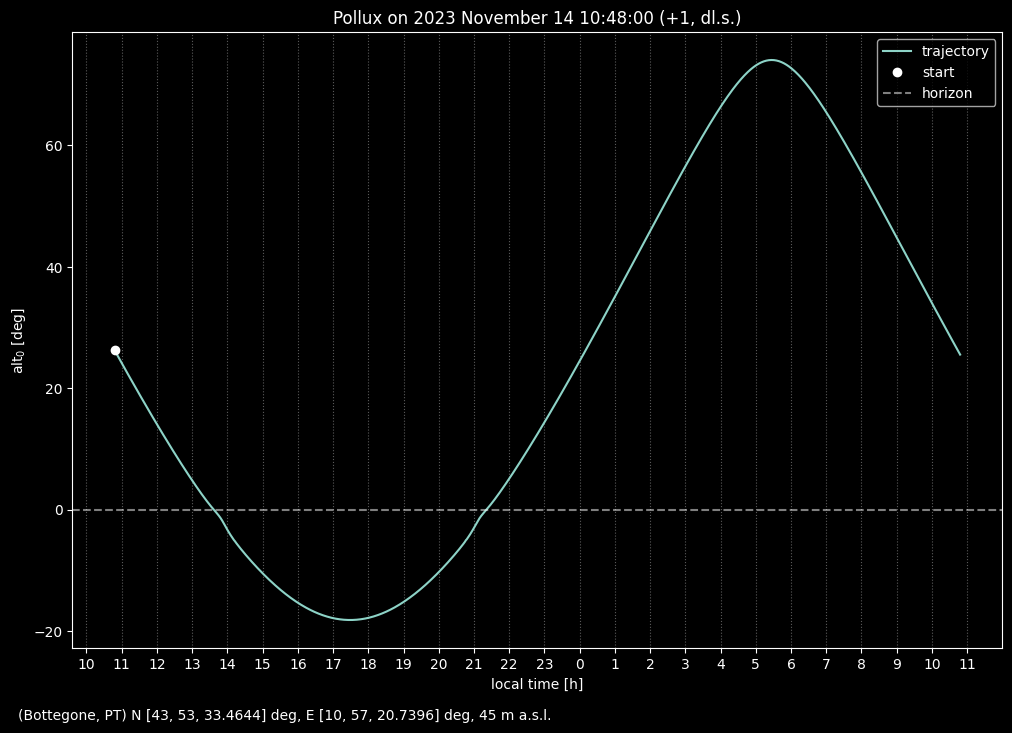

In [143]:
## Some applications

# length of the resulting arrays
numpoint = 1000

# setting the output of time in the plot
# I want the time measured in the
# observatory location
out = 'local time'

# observatory location
lat = 43.892629
lon = -10.955761 
h = 45
obsname = 'Bottegone, PT'
obs = GeoPos(lon,lat,h,name=obsname)

# getting target data
name, ra, dec, prmt = import_data('targets.csv',sel=4)
obj = StarObj(name,[ra,dec],prmt=prmt)
obj.obj_info()
print()

# setting time zone, daylight saving and date 
timezone, dl_save = 1, True
date = Date([2023,11,14],[10,48,0],timezone=timezone,dl_save=dl_save)

# printing informations
print('Observation on ' + date.ut_to_local(timezone,dl_save,'str') + ' ==> ' + date.print_date())
print('From an observer in '+ obs.place_info())

# computing the apparent altitude
alt, dayrange = trajectory(date,obs,obj,numpoint) 

## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)
if out[:5] == 'local':
    hzone = timezone
    if dl_save: hzone += 1
elif out == 'UT':
    hzon = 0

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
titledate = date.print_date() if out == 'UT' else date.ut_to_local(timezone,dl_save,'str')
plt.title(obj.name + ' on ' + titledate)

plt.plot(dayrange,alt.deg,label='trajectory')
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')

labelticks = np.round(ticks.time.hour() + hzone,0).astype(int)
labelticks = np.where(labelticks >= 24, labelticks-24, labelticks)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.xticks(ticks.jd,labelticks)
plt.xlabel(out + ' [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)
location_string = obs.place_info(True)
plt.text(0.08, 0.02, location_string, fontsize=10, transform=plt.gcf().transFigure)

plt.show()

#### <a id='toc1_3_2_5_'></a>[III.2.5 Transit, rising and setting](#toc0_)



In [144]:
def tran_ris_set(date: Date, obs_pos: GeoPos, obj: StarObj, results: bool = False, iter: int = 3) -> Time:
    """Computing the time of transit, rising and setting

    Firsly, function computes the time of the transit and checks the presence of
    setting and rising (that is the target star is circumpolar or not). 

    The routine to compute these times is a recursive method, then one can change
    the number of iterations through parameter `iter`.   

    :param date: date for which to compute the analisys
    :type date: Date
    :param obs_pos: observatory location
    :type obs_pos: GeoPos
    :param obj: target star
    :type obj: StarObj
    :param results: if `True` results are printed, defaults to `False`
    :type results: bool, optional
    :param iter: number of iterations, defaults to `3`
    :type iter: int, optional

    :return: time for transit and (if there are) setting and rising 
    :rtype: Time
    """
    date = date.copy()
    lon = obs_pos.lon
    lat = obs_pos.lat
    height = obs_pos.h
    # computing the GST for the meridian in date at 0h UT
    tmpdate = Date(date.date,0.)
    Dt = time_correction(tmpdate.date[0])
    GST0 = Green_ST(tmpdate,True,obj.epoch)
    # computing r.a. and dec. on nearest days
    # (previous and consecutive one) at 0h TD     
    tmpdate = Date(date.date,0.,timetype='TD')
    jd = tmpdate.jd
    a1, d1 = obj.coor_in_date(tmpdate-1)
    a2, d2 = obj.coor_in_date(tmpdate)
    a3, d3 = obj.coor_in_date(tmpdate+1)
    del tmpdate

    # transit computation in decimals of a day
    mt = (a2 + lon - GST0).deg / 360 
    # checking the value       
    if abs(mt) > 1:
        mt -= np.sign(mt)
    elif mt < 0:
        mt += 1
    # routine
    for k in range(iter):
        # computing the corresponding GST
        GST = GST0.deg + 360.985647*mt
        # checking the value       
        if GST > 360:
            GST -= 360*int(GST/360)
        GST = HAngles(GST,'deg')
        # converting from TD to UT
        n = mt + Dt/Time.DAYSEC
        # computing the corresponging r.a.
        a = interpole_three([a1.deg,a2.deg,a3.deg],n+jd,[jd-1,jd,jd+1])
        a = HAngles(a,'deg')
        # computing the HA
        H = GST - lon - a
        # correcting the previous computation
        Dmt = - H.deg/360
        mt += Dmt
        # checking the value       
        if abs(mt) > 1:
            mt -= np.sign(mt)
        elif mt < 0:
            mt += 1
    time = date.time
    # checking the value       
    if mt*24 < time.hour():
        mt += 1
    # saving the result in seconds 
    m = Time(mt*Time.DAYSEC)
    # condition to print the result
    if results:
        print()
        transit = Date(date.date,m,calendar=date.calendar)
        print('transit:\t' + transit.print_date() + ' ==> ' + transit.ut_to_local(timezone,dl_save,'str'))
    
    # rising and setting
    # true altitude for a zero apparent altitude  
    h0 = refraction_corr(Angles(0.,'deg',lim=90),height, alt0=True)
    # computing approximated value for HA
    cosH0 = (np.sin(h0.rad) - np.sin(lat.rad)*np.sin(d2.rad)) / (np.cos(lat.rad)*np.cos(d2.rad))
    # checking the presence of rising and setting
    if abs(cosH0) <= 1:
        H0 = HAngles(np.arccos(cosH0),'rad',lim=180)
        # time of rising and setting in decimals of a day
        mr = mt - H0.deg/360
        ms = mt + H0.deg/360
        # generalizing the method 
        m = np.array([mr,ms])
        # checking the value       
        m = np.where(abs(m) > 1, m-np.sign(m), m)
        m = np.where(m < 0, m+1, m)
        # routine
        for k in range(iter):
            # computing the corresponding GST
            GST = GST0.deg + 360.985647*m
            # checking the value       
            GST = np.where(GST > 360, GST - 360*(GST/360).astype(int), GST)               
            GST = HAngles(GST,'deg')
            # converting from TD to UT
            n = m + Dt/Time.DAYSEC
            # computing the corresponging r.a.
            a = np.array([interpole_three([a1.deg,a2.deg,a3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
            a = HAngles(a,'deg')
            # computing the corresponging dec.
            d = np.array([interpole_three([d1.deg,d2.deg,d3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
            d = HAngles(d,'deg',lim=90) 
            # computing the HA
            H = GST - lon - a
            # computing corresponding altitude
            h = np.arcsin(np.sin(lat.rad)*np.sin(d.rad) + np.cos(lat.rad)*np.cos(d.rad)*np.cos(H.rad))
            h = Angles(h,'rad',lim=90)
            # correcting the previous computation
            Dm = (h-h0).deg / (360 * (np.cos(d.rad)*np.cos(lat.rad)*np.sin(H.rad)))
            m += Dm
            # checking the value       
            m = np.where(abs(m) > 1, m-np.sign(m), m)
            m = np.where(m < 0, m+1, m)
        
        # checking the value       
        m = np.where(m*24 < time.hour(), m+1, m)
        m = Time(m*Time.DAYSEC)    
        # condition to print the results
        if results:
            mr, ms = m.val
            rising  = Date(date.date,Time(mr),calendar=date.calendar)
            setting = Date(date.date,Time(ms),calendar=date.calendar)

            event = [rising,setting]
            names = ['rising ','setting']
            for i in range(2):
                print(names[i] + ':\t' + event[i].print_date() + ' ==> ' + event[i].ut_to_local(timezone,dl_save,'str'))
        # updating the variable of the results
        m.val = np.append(mt*Time.DAYSEC,m.val)
    return m


2023 November 14 10:48:00 (+1, dl.s.)

transit:	2023 November 15 03:30:57.9966 UT ==> 2023 November 15 05:30:57.9966 (+1, dl.s.)
rising :	2023 November 14 19:21:16.1882 UT ==> 2023 November 14 21:21:16.1882 (+1, dl.s.)
setting:	2023 November 14 11:36:43.9154 UT ==> 2023 November 14 13:36:43.9154 (+1, dl.s.)


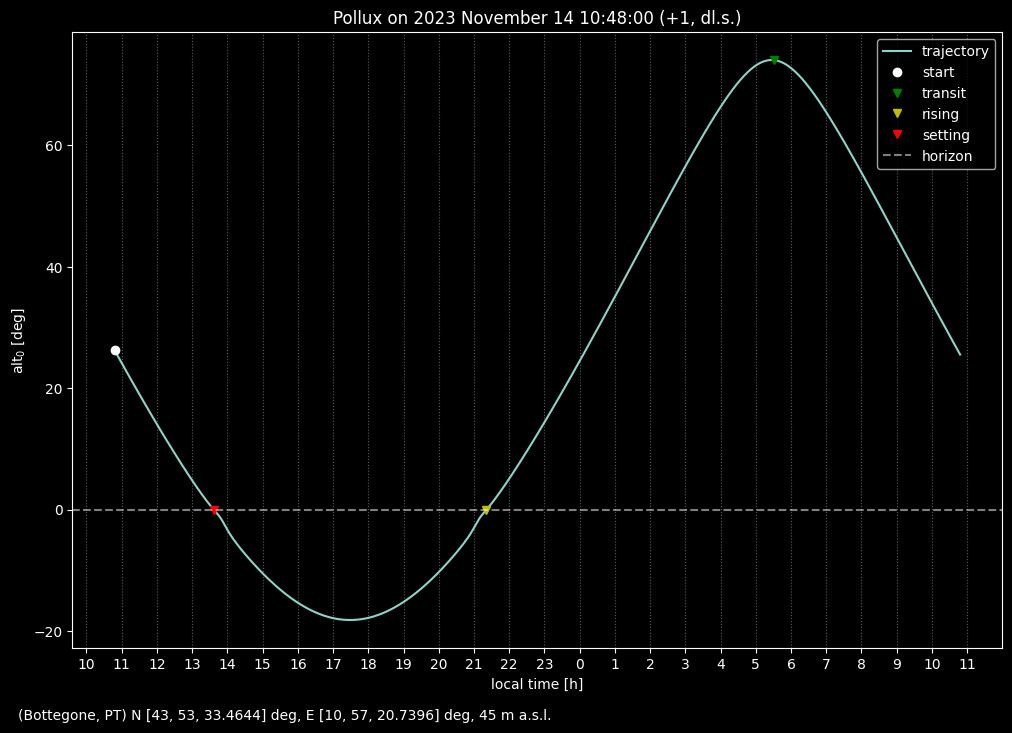

In [145]:
print(date.ut_to_local(timezone,dl_save,'str'))

# computing the time of the events
m = tran_ris_set(date,obs,obj,True)
event = Date(date.date,m)
# computing the corresponding apparent altitude
ealt = compute_alt(event,obs,obj,True)


## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
titledate = date.print_date() if out == 'UT' else date.ut_to_local(timezone,dl_save,'str')
plt.title(obj.name + ' on ' + titledate )

plt.plot(dayrange,alt.deg,label='trajectory')
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')
if type(m.val) != np.ndarray:
    plt.plot(event.jd,ealt.deg,'vg',label='transit')
else:
    plt.plot(event.jd[0],ealt.deg[0],'vg',label='transit')
    plt.plot(event.jd[1],ealt.deg[1],'vy',label='rising')
    plt.plot(event.jd[2],ealt.deg[2],'vr',label='setting')


labelticks = np.round(ticks.time.hour() + hzone,0).astype(int)
labelticks = np.where(labelticks >= 24, labelticks-24, labelticks)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.xticks(ticks.jd,labelticks)
plt.xlabel(out + ' [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)
location_string = obs.place_info(True)
plt.text(0.08, 0.02, location_string, fontsize=10, transform=plt.gcf().transFigure)


plt.show()


## <a id='toc1_4_'></a>[IV. Sun](#toc0_)

In [146]:
class Sun():
    """_summary_

    :raises Exception: _description_
    :raises Exception: _description_
    :raises Exception: _description_
    :raises Exception: _description_
    :raises Exception: _description_
    :return: _description_
    :rtype: _type_
    """

    AU = 1.49597870707e8 # km

    def __init__(self):
        """_summary_
        """
        # mean longitude referred to the mean equinox 
        self.L = Angles(280.46646,'deg')
        # mean anomaly
        self.M = Angles(357.52911,'deg')
        # eccentricity
        self.ecc = 1.6708634e-2
        # epoch
        self.epoch = 'J2000.0'
    
    def mean_coor(self, date: Date, sel: str = 'LM') -> tuple[Angles, Angles] | Angles:
        """_summary_

        :param date: _description_
        :type date: Date
        :param sel: _description_, defaults to 'LM'
        :type sel: str, optional
        :raises Exception: _description_
        :return: _description_
        :rtype: tuple[Angles, Angles] | Angles
        """
        # list to store results
        results = []
        # mean longitude for epoch J2000
        L = self.L.deg
        # mean anomaly for epoch J2000
        M = self.M.deg
        # 
        date = date.copy()
        date = date.change_time_type('TD')
        T = (date.jd - Date.J2000)/36525
        # computing mean longitude
        if 'L' in sel:
            L += 36000.76983*T + 3.032e-4*(T**2)
            # for array type
            if type(L) == np.ndarray:
                L = np.where(abs(L) > 360, L % 360, L)
                # L = np.where(abs(L) > 360, L-(L//360)*360, L)
                L = np.where(L < 0, L+360, L)
            else:
                if abs(L) > 360: L -= (L//360)*360
                if L < 0: L += 360
            # print('L',L)
            # storing the result
            results += [Angles(L,'deg')]
        # computing mean anomaly
        if 'M' in sel:
            M += 35999.05029*T - 1.537e-4*(T**2) 
            # for array type
            if type(M) == np.ndarray:
                M = np.where(abs(M) > 360, M % 360, M)
                # M = np.where(abs(M) > 360, M-(M//360)*360, M)
                M = np.where(M < 0, M+360, M)            
            else:
                if abs(M) > 360: M -= (M//360)*360
                if M < 0: M += 360
            # print('M',M)
            # storing the result
            results += [Angles(M,'deg')]
        if len(results) == 1: results = results[0]
        # only 
        elif len(results) == 0: raise Exception(f"Error in selection! '{sel}' is not allowed")
        return results
    
    def ecc_in_date(self, date: Date) -> float | np.ndarray:
        """_summary_

        :param date: _description_
        :type date: Date
        :return: _description_
        :rtype: float | np.ndarray
        """
        date = date.copy()
        date = date.change_time_type('TD')
        T = (date.jd - Date.J2000)/36525
        return self.ecc - (4.2037e-5*T + 1.267e-7*(T**2))

    def orbit_in_date(self, date: Date, sel: str = 'all', true_val: bool = True) -> list[Angles | float] | Angles | float:
        date = date.copy()
        results = []
        L, M = self.mean_coor(date)
        if true_val:
            date = date.change_time_type('TD')
            T = (date.jd - Date.J2000)/36525
            C =  (1.914602 - 4.817e-3*T - 1.4e-5*(T**2))*np.sin(M.rad)  
            C += (1.9993e-2 - 1.01e-4*T) * np.sin(2*M.rad)
            C += 2.89e-4 * np.sin(3*M.rad)
            C = Angles(C,'deg')
            # print('C',C.deg)
            # true long referred to the mean equinox
            L = L + C
            # true anomaly
            M = M + C
        if ('L' in sel) or (sel == 'all'):
            if type(L.deg) == np.ndarray:
                L = L - np.where(abs(L) > 360, (L.deg//360)*360, 0).astype(float)
                L = L + np.where(L < 0, 360, 0).astype(float)
            else:
                if abs(L) > 360: L = L % 360 #L -= (L.deg//360)*360
                if L < 0: L += 360
            # print('l',L.deg,L.print_angle('deg',True))
            results += [L]
        if ('M' in sel) or (sel == 'all'):
            if type(M.deg) == np.ndarray:
                M = M - np.where(abs(M) > 360, (M//360)*360, 0).astype(float)
                M = M + np.where(M < 0, 360, 0).astype(float)
            else:
                if abs(M) > 360: M = M % 360 #M -= (M//360)*360
                if M < 0: M += 360
            # print('nu',M.deg)
            results += [M]
        if ('e' in sel) or (sel == 'all'):
            ecc = self.ecc_in_date(date)
            # print('ecc',ecc)
            results += [ecc]
        if len(results) == 1: results = results[0]
        elif len(results) == 0: raise Exception(f"Error in selection! '{sel}' is not allowed")        
        return results

    def app_lon(self,date: Date) -> Angles:
        date = date.copy()
        date = date.change_time_type('TD')
        # apparent longitude referred to the true equinox
        L = self.orbit_in_date(date,'L') 
        T = (date.jd - Date.J2000)/36525
        Om = 125.04 - 1934.136*T
        # print('Om',Om)
        l = L.deg - 5.69e-3 - 4.78e-3*np.sin(Angles(Om,'deg').rad)
        return Angles(l,'deg')

    def equat_coor(self, date: Date, sel:str = 'all', app_val: bool = True) -> tuple[HAngles, Angles] | HAngles | Angles:
        e = mean_obliquity(date)
        # print('e0',e.deg)
        if app_val: 
            L = self.app_lon(date)
            _, De = nutation_corr(date)
            e += De
            # print('lon',L.deg,L.print_angle('deg',True))
            # print('e',e.deg)
        else: 
            L = self.orbit_in_date(date,'L')
        
        coor = Ecliptical(L, 0.)
        coor = eclipt_to_equat(coor,e)
        if type(L.deg) == np.ndarray: 
           coor.alpha = coor.alpha + np.where(coor.alpha < 0, 360, 0).astype(float)
        elif coor.alpha < 0: 
            coor.alpha = coor.alpha + 360
        if   sel == 'ra' : return coor.alpha
        elif sel == 'dec': return coor.delta
        elif sel == 'all': return coor.alpha, coor.delta
        else: raise Exception(f"Error in selection! '{sel}' is not allowed")        

    def distance(self, date: Date) -> float | np.ndarray:
        nu, ecc = self.orbit_in_date(date,'Me')
        r = 1.000001018 * ((1-ecc**2)/(1+ecc*np.cos(nu.rad)))
        return r
    
    def ang_diameter(self, date: Date) -> Angles:
        nu, ecc = self.orbit_in_date(date,'Me')
        D = 0.533128 * ((1+ecc*np.cos(nu.rad))/(1-ecc**2))
        return Angles(D,'deg')

    def aberration_corr(self, date: Date, obj_coor: Equatorial, sel: str = 'all') -> HAngles | Angles | tuple[HAngles, Angles]:
        date = date.copy().change_time_type('TD')
        k = Angles(['+',[0,0,20.49552]],'deg')
        e = mean_obliquity(date)
        # _, De = nutation_corr(date)
        # e = e + De
        ecl_coor = equat_to_eclipt(obj_coor,e)
        lon, lat = ecl_coor.lon, ecl_coor.lat
        T = (date.jd - Date.J2000)/36525
        # print('T',T)
        peri = 102.93735 + 1.71946*T + 4.6e-4*(T**2)
        # print('pi',peri)
        peri = Angles(peri,'deg')
        L, ecc = self.orbit_in_date(date,'Le')
        # print('L',L.deg)
        # print('ecc',ecc)    
        Dlon = -k*(np.cos(L.rad-lon.rad)-ecc*np.cos(peri.rad-lon.rad))/np.cos(lat.rad)
        Dlat = -k*np.sin(lat.rad)*(np.sin(L.rad-lon.rad)-ecc*np.sin(peri.rad-lon.rad))
        Dlat.lim = 90
        lon = lon + Dlon
        lat = lat + Dlat
        corr_coor = eclipt_to_equat(Ecliptical(lon,lat),e)
        if sel != 'dec':
            Dra = corr_coor.alpha - obj_coor.alpha
            if sel == 'ra': return Dra
        if sel != 'ra':
            Ddec = corr_coor.delta - obj_coor.delta
            Ddec.lim = 90
            if sel == 'dec': return Ddec
        if sel != 'all': raise Exception(f'Error in selection!\n`{sel}` is not allowed')
        else: return Dra, Ddec

    def corr_coor(self, date: Date, sel: str = 'all', app_val: bool = True) -> HAngles | Angles | tuple[HAngles, Angles]:
        alpha, delta = self.equat_coor(date,app_val=app_val)
        coor = Equatorial(alpha, delta)
        aberr = self.aberration_corr(date,coor,sel)
        e = mean_obliquity(date)
        Dlon, De = nutation_corr(date)

        # condition for right ascension only
        if sel == 'ra':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(delta.rad)) - De*(np.cos(alpha.rad)*np.tan(delta.rad))
            ra = alpha + Dra + aberr
            if type(ra.deg) == np.ndarray:
                ra = ra - np.where(ra < 0, (ra.deg//360)*360, 0).astype(float)
            elif ra < 0:
                ra = ra % 360
                # ra = ra - ((ra.deg//360)*360)
            return ra
        # condition for declination only
        elif sel == 'dec':
            Ddec = Dlon*(np.sin(e.rad)*np.cos(alpha.rad))+ De*np.sin(alpha.rad)
            Ddec.lim = 90
            dec = delta + Ddec + aberr
            return dec
        # condition for both results
        elif sel == 'all':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(delta.rad)) - De*(np.cos(alpha.rad)*np.tan(delta.rad))
            Ddec = Dlon*(np.sin(e.rad)*np.cos(alpha.rad))+ De*np.sin(alpha.rad)
            Ddec.lim = 90
            Dra2, Ddec2 = aberr 
            ra = alpha + Dra + Dra2
            dec = delta + Ddec + Ddec2
            if type(ra.deg) == np.ndarray:
                ra = ra - np.where(ra < 0, (ra.deg//360)*360, 0).astype(float)
            elif ra < 0:
                ra = ra % 360
                # ra = ra - ((ra.deg//360)*360)
            return ra, dec
        else: raise Exception(f'Error in selection!\n`{sel}` is not allowed')

    def rise_set(self, date: Date, obs_pos: GeoPos, results: bool = True, iter: int = 3) -> Time | None:
        date = date.copy()
        lon = obs_pos.lon
        lat = obs_pos.lat
        height = obs_pos.h
        # computing the GST for the meridian in date at 0h UT
        tmpdate = Date(date.date,0.)
        Dt = time_correction(tmpdate.date[0])
        GST0 = Green_ST(tmpdate,True)
        # computing r.a. and dec. on nearest days
        # (previous and consecutive one) at 0h TD     
        tmpdate = Date(date.date,0.,timetype='TD')
        jd = tmpdate.jd
        a1, d1 = self.corr_coor(tmpdate-1)
        a2, d2 = self.corr_coor(tmpdate)
        a3, d3 = self.corr_coor(tmpdate+1)
        # true altitude for a zero apparent altitude  
        h0 = refraction_corr(Angles(0.,'deg',lim=90),height, alt0=True) - self.ang_diameter(tmpdate)/2
        del tmpdate
        # transit computation in decimals of a day
        mt = (a2 + lon - GST0).deg / 360 
        # checking the value       
        if abs(mt) > 1:
            mt -= np.sign(mt)
        elif mt < 0:
            mt += 1
        # rising and setting
        # computing approximated value for HA
        cosH0 = (np.sin(h0.rad) - np.sin(lat.rad)*np.sin(d2.rad)) / (np.cos(lat.rad)*np.cos(d2.rad))
        # checking the presence of rising and setting
        if abs(cosH0) <= 1:
            H0 = HAngles(np.arccos(cosH0),'rad',lim=180)
            # time of rising and setting in decimals of a day
            mr = mt - H0.deg/360
            ms = mt + H0.deg/360
            # generalizing the method 
            m = np.array([mr,ms])
            # checking the value       
            m = np.where(abs(m) > 1, m-np.sign(m), m)
            m = np.where(m < 0, m+1, m)
            # routine
            for k in range(iter):
                # computing the corresponding GST
                GST = GST0.deg + 360.985647*m
                # checking the value       
                GST = np.where(GST > 360, GST - 360*(GST/360).astype(int), GST)               
                GST = HAngles(GST,'deg')
                # converting from TD to UT
                n = m + Dt/Time.DAYSEC
                # computing the corresponging r.a.
                a = np.array([interpole_three([a1.deg,a2.deg,a3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                a = HAngles(a,'deg')
                # computing the corresponging dec.
                d = np.array([interpole_three([d1.deg,d2.deg,d3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                d = HAngles(d,'deg',lim=90) 
                # computing the HA
                H = GST - lon - a
                # computing corresponding altitude
                h = np.arcsin(np.sin(lat.rad)*np.sin(d.rad) + np.cos(lat.rad)*np.cos(d.rad)*np.cos(H.rad))
                h = Angles(h,'rad',lim=90)
                # correcting the previous computation
                Dm = (h-h0).deg / (360 * (np.cos(d.rad)*np.cos(lat.rad)*np.sin(H.rad)))
                m += Dm
                # checking the value       
                m = np.where(abs(m) > 1, m-np.sign(m), m)
                m = np.where(m < 0, m+1, m)
            
            time = date.time
            # checking the value       
            m = np.where(m*24 < time.hour(), m+1, m)
            m = Time(m*Time.DAYSEC)    
            # condition to print the results
            if results:
                mr, ms = m.val
                rising  = Date(date.date,Time(mr),calendar=date.calendar)
                setting = Date(date.date,Time(ms),calendar=date.calendar)

                event = [rising,setting]
                names = ['rising ','setting']
                for i in range(2):
                    print(names[i] + ':\t' + event[i].print_date() + ' ==> ' + event[i].ut_to_local(timezone,dl_save,'str'))
            return m
        else:
            if results:
                res_str = 'rises' if cosH0 > 0 else 'sets'
                print('Sun never ' + res_str)
            return None
        
    def twilight(self, date: Date, obs_pos: GeoPos, tw_type: str = 'astro') -> Time | None:
        tw = {
            'astro': -18,
            'civil':  -6,
            'nauti': -12
        }
        m = self.rise_set(date,obs_pos,True)
        if m is None:
            return None
        else:
            lat = obs_pos.lat
            height = obs_pos.h
            rise, set = m.val
            secinday = Time.DAYSEC
            tmpdate = Date(date.date,0.,timetype='TD')
            dec = self.corr_coor(tmpdate,'dec')
            h = Angles(tw[tw_type],'deg')
            h0 = h + refraction_corr(h,height,True)-self.ang_diameter(tmpdate)/2
            del tmpdate
            H  = np.arccos(-np.tan(lat.rad)*np.tan(dec.rad))
            H1 = np.arccos((np.sin(h0.rad) - np.sin(lat.rad)*np.sin(dec.rad)) / (np.cos(lat.rad)*np.cos(dec.rad)))
            t  = HAngles.rad_to_hms(H1-H)
            t *= 0.9973
            if t > 24: t %= 24 #t -= (t//24)*24
            if t < 0 : t += 24
            print(f'Twilight -> {t:.3f} h') 
            t *= 3600
            mtw = rise - t
            if mtw < date.time.val: mtw += secinday
            etw = set + t
            if etw < date.time.val: etw += secinday
            mor = Date(date.date,Time(mtw),calendar=date.calendar) 
            eve = Date(date.date,Time(etw),calendar=date.calendar)
            print('morning:\t'+mor.print_date()+' ==> '+mor.ut_to_local(timezone,dl_save,'str'))
            print('evening:\t'+eve.print_date()+' ==> '+eve.ut_to_local(timezone,dl_save,'str'))
            twm = Time(np.array([mtw,etw]))
            return twm







+[15, 15, 35.5225] hms
-[18, 5, 26.2028] deg

!warning: you are subtracting angles with different limits: 90 and 360!
The limit of the sum is taken equal to that of ang1

rising :	2023 August 11 04:14:03.8669 UT ==> 2023 August 11 06:14:03.8670 (+1, dl.s.)
setting:	2023 August 11 18:28:19.7737 UT ==> 2023 August 11 20:28:19.7737 (+1, dl.s.)

!warning: you are subtracting angles with different limits: 90 and 360!
The limit of the sum is taken equal to that of ang1

rising :	2023 August 11 04:14:03.8669 UT ==> 2023 August 11 06:14:03.8670 (+1, dl.s.)
setting:	2023 August 11 18:28:19.7737 UT ==> 2023 August 11 20:28:19.7737 (+1, dl.s.)

!warning: you are summing angles with different limits: 360 and 90!
The limit of the sum is taken equal to that of ang1

Twilight -> 2.024 h
morning:	2023 August 11 02:12:36.8938 UT ==> 2023 August 11 04:12:36.8938 (+1, dl.s.)
evening:	2023 August 11 20:29:46.7469 UT ==> 2023 August 11 22:29:46.7469 (+1, dl.s.)


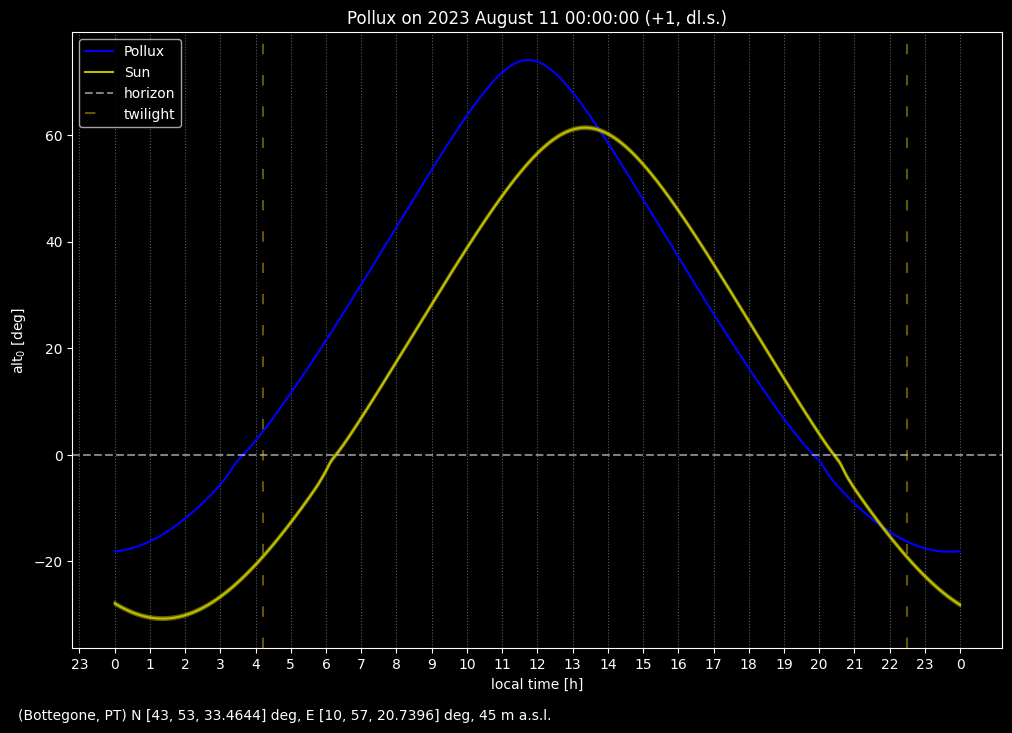

Theta Persei
Equatorial Coordinates for epoch J2000:
alpha:	+[2, 44, 11.9860] hms
delta:	+[49, 13, 42.4800] deg
+[2, 46, 11.3310] hms
+[49, 20, 54.5356] deg
Dlon +[0, 0, 15.0373]
Deps +[0, 0, 2.6653]
eps0 23.435537179168147
Da1 +[0, 0, 18.4389] deg Dd1 +[0, 0, 6.2436] deg
Da2 +[0, 0, 30.0460] deg Dd2 +[0, 0, 6.6961] deg
Da +[0, 0, 3.2323] hms
Dd +[0, 0, 12.9397] deg
+[2, 46, 14.5633] hms
+[49, 21, 7.4753] deg


In [147]:


SUN = Sun()


date = Date([2028,11,13.19],0,timetype='TD')
ra, dec = SUN.corr_coor(date)
print(ra.print_angle('hms', True))
print(dec.print_angle('deg', True))


#######
timezone, dl_save = 1, True
date = Date([2023,8,11],timezone=timezone,dl_save=dl_save)

alt, dayrange = trajectory(date,obs,obj,numpoint) 

dates = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar)
ra, dec = SUN.corr_coor(dates)
lon = obs.lon
lat = obs.lat
lst = local_ST(dates,lon,True)
lha = lst - ra
altaz = equat_to_altaz(Equatorial(ra,dec),lha,lat)
sunrad = SUN.ang_diameter(dates)/2
sunalt = altaz.alt + refraction_corr(altaz.alt,obs.h)
sunrs = SUN.rise_set(date,obs)
sunrs = Date(date.date,sunrs,calendar=date.calendar)
suntw = SUN.twilight(date,obs)
suntw = Date(date.date,suntw,calendar=date.calendar)


## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)
if out[:5] == 'local':
    hzone = timezone
    if dl_save: hzone += 1
elif out == 'UT':
    hzon = 0

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
titledate = date.print_date() if out == 'UT' else date.ut_to_local(timezone,dl_save,'str')
plt.title(obj.name + ' on ' + titledate)
plt.plot(dayrange,alt.deg,'b',label=obj.name)
plt.plot(dayrange,sunalt.deg,'y',label='Sun')
plt.plot(dayrange,sunalt.deg - sunrad.deg,'y',alpha=0.5)
plt.plot(dayrange,sunalt.deg + sunrad.deg,'y',alpha=0.5)
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)
labelticks = np.round(ticks.time.hour() + hzone,0).astype(int)
labelticks = np.where(labelticks >= 24, labelticks-24, labelticks)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.axvline(suntw.jd[0],ymin=0,ymax=1,linestyle=(0,(5,10)),alpha=0.4,color='gold',label='twilight')
plt.axvline(suntw.jd[1],ymin=0,ymax=1,linestyle=(0,(5,10)),alpha=0.4,color='gold')
plt.xticks(ticks.jd,labelticks)
plt.xlabel(out + ' [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)
location_string = obs.place_info(True)
plt.text(0.08, 0.02, location_string, fontsize=10, transform=plt.gcf().transFigure)
plt.show()

######

date = Date([2028,11,13.19],0,timetype='TD')
obj_coor = Equatorial(HAngles(['+',[2,44,11.986]],'hms'),Angles(['+',[49,13,42.48]], 'deg',90))
prmt = [0.03425*15,-0.0895]
a, d = precession_corr(date,obj_coor.alpha,obj_coor.delta,prmt=prmt)
print('Theta Persei')
print(obj_coor.print_values(eph='J2000'))

print(a.print_angle('hms',True))
print(d.print_angle('deg',True))

Dlon, De = nutation_corr(date)
print('Dlon',Dlon.print_angle('deg'))
print('Deps',De.print_angle('deg'))
e = mean_obliquity(date)
print('eps0',e.deg)
Da1 = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(d.rad)) - De*(np.cos(a.rad)*np.tan(d.rad))
Da1 = HAngles(Da1.deg,'deg')
Dd1 = Dlon*(np.sin(e.rad)*np.cos(a.rad))+ De*np.sin(a.rad)
Dd1.lim = 90
print('Da1',Da1.print_angle('deg',True),'Dd1',Dd1.print_angle('deg',True))
Da2, Dd2 = SUN.aberration_corr(date,Equatorial(a,d))
print('Da2',Da2.print_angle('deg',True),'Dd2',Dd2.print_angle('deg',True))
Da = Da1 + Da2
Dd = Dd1 + Dd2
print('Da',Da.print_angle('hms',True))
print('Dd',Dd.print_angle('deg',True))
a = a + Da
d = d + Dd
print(a.print_angle('hms',True))
print(d.print_angle('deg',True))


### <a id='toc1_4_1_'></a>[IV.I Aberration correction](#toc0_)

In [148]:
class StarObj():
    """Class to store informations about a target star

    This object collects the name of the target, its equatorial
    coordinates, the standard epoch of the coordinates and 
    proper motion in right ascension and declination if one has 
    these informations

    The attributes of the class are:

    :ivar name: name of the target star
    :vartype name: str
    :ivar coor: equatorial coordinates of the target
    :vartype coor: Equatorial
    :ivar epoch: standard epoch
    :vartype epoch: str
    :ivar mua: velocity in r.a. [as/yrs]
    :vartype mua: float
    :ivar mud: velocity in dec. [as/yrs]
    :vartype mud: float
    
    """
    def __init__(self, name: str, coor: Equatorial | list[HAngles | float | list], epoch: str = 'J2000.0', prmt: list[float] | None = None) -> None:
        """Constructor of the class

        One can pass coordinates as `Equatorial` object or a list of `HAngles` object, 
        of list angle or of float.

        :param name: the name of the target
        :type name: str
        :param coor: equatorial coordinates
        :type coor: Equatorial | list[HAngles  |  float  |  list]
        :param epoch: standard epoch of coordinates, defaults to `'J2000.0'`
        :type epoch: str, optional
        :param prmt: informations of proper motion, defaults to `None`
        :type prmt: list[float] | None, optional
        """
        # condition for not-`Equatorial` object 
        if type(coor) == list:
            ra, dec = coor
            coor = Equatorial(ra,dec)
        
        self.name = name
        self.coor = coor.copy()
        self.epoch = epoch
        self.mua = prmt[0] if prmt is not None else None
        self.mud = prmt[1] if prmt is not None else None
    
    def copy(self):
        """Function to get an exact copy of the object

        :return: the exact copy of the object
        :rtype: StarObj
        """
        # checking if proper motion informations are present
        prmt = [self.mua, self.mud] if self.mua is not None else None
        return StarObj(self.name,self.coor,self.epoch,prmt)

    def obj_info(self) -> None:
        """Function to print target informations
        """
        print('Target: ' + self.name)
        print(self.coor.print_values(eph=self.epoch))
        # checking if proper motion informations are present
        if self.mua is not None:
            print('Proper motion')
            print(f'mu_alpha =\t{self.mua} as/yr\nmu_delta =\t{self.mud} as/yr')
        print()

    def getcoor(self, sel: str = 'all') -> HAngles | tuple[HAngles]:
        """Function to extract the stored coordinates of the star

        One can select which coordinate value to extract 
        through `sel` parameter:

          * `sel = 'ra'`: only right ascension of the star is returned 
          * `sel = 'dec'`: only declination of the star is returned 
          * `sel = 'all'`: both 

        :param sel: selection parameter, defaults to `'all'`
        :type sel: str, optional
        
        :return: right ascension or/and declination of the target star
        :rtype: HAngles | tuple[HAngles]
        
        :raises Exception: only values in docstring are allowed for `sel` parameter
        """
        starobj = self.copy()
        if   sel == 'ra' : return starobj.coor.alpha
        elif sel == 'dec': return starobj.coor.delta
        elif sel == 'all': return starobj.coor.alpha, starobj.coor.delta
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def getprmt(self, sel: str = 'all') -> float | list[float] | None:
        """Function to extract the stored information on proper motion

        One can select which proper motion value to extract 
        through `sel` parameter:

          * `sel = 'mua'`: only proper motion in right ascension is returned 
          * `sel = 'mud'`: only proper motion in declination is returned 
          * `sel = 'all'`: both 

        :param sel: selection parameter, defaults to 'all'
        :type sel: str, optional
        
        :return: proper motion in r.a. and/or in dec. if there is
        :rtype: float | list[float] | None

        :raises Exception: only values in docstring are allowed for `sel` parameter
        """
        starobj = self.copy()
        # checking the presence of proper motion informations
        if self.mua is None and self.mud is None: return None
        elif sel == 'mua': return starobj.mua
        elif sel == 'mud': return starobj.mud
        elif sel == 'all': return [starobj.mua, starobj.mud]
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')

    def coor_in_date(self, date: Date, sel: str = 'all') -> HAngles | tuple[HAngles, HAngles]:
        """Function to extract equatorial coordinates of the target at a precise date

        Coordinates of `StarObj` class are referred to the 
        stored standard epoch. This function computes the 
        coordinates for an arbitrary epoch from `self.epoch`. 

        One can select which coordinate value to extract 
        through `sel` parameter:

          * `sel = 'ra'`: only right ascension of the star is returned 
          * `sel = 'dec'`: only declination of the star is returned 
          * `sel = 'all'`: both 

        :param date: date for which to compute coordinates
        :type date: Date
        :param sel: selection parameter, defaults to 'all'
        :type sel: str, optional

        :return: right ascension and/or declination for chosen date
        :rtype: HAngles | tuple[HAngles, HAngles]
        
        :raises Exception: only values in docstring are allowed for `sel` parameter
        """
        # getting coordinates computed for standard epoch
        ra, dec = self.getcoor()
        # getting standard epoch
        epoch = self.epoch
        # getting informations about proper motion
        prmt = self.getprmt()
        # computing precession and nutation corrections
        ra, dec  = precession_corr(date,ra,dec,epoch,prmt)
        Dlon, De = nutation_corr(date)
        e = De + mean_obliquity(date)
        aberr = SUN.aberration_corr(date,Equatorial(ra,dec),sel)
        # condition for right ascension only
        if sel == 'ra':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(dec.rad)) - De*(np.cos(ra.rad)*np.tan(dec.rad))
            ra = ra + Dra + aberr
            return ra
        # condition for declination only
        elif sel == 'dec':
            Ddec = Dlon*(np.sin(e.rad)*np.cos(ra.rad))+ De*np.sin(ra.rad)
            Ddec.lim = 90
            dec = dec + Ddec + aberr
            return dec
        # condition for both results
        elif sel == 'all':
            Dra = Dlon*(np.cos(e.rad)+np.sin(e.rad)*np.tan(dec.rad)) - De*(np.cos(ra.rad)*np.tan(dec.rad))
            Ddec = Dlon*(np.sin(e.rad)*np.cos(ra.rad))+ De*np.sin(ra.rad)
            Ddec.lim = 90
            Dra1, Ddec1 = aberr
            ra = ra + Dra + Dra1
            dec = dec + Ddec + Ddec1
            return ra, dec
        else: raise Exception(f'Wrong selection!\n`{sel}` is not allowed.')
    
    def lha(self, date: Date, lon: Angles) -> HAngles:
        """Function to compute the local hour angle

        Terrestrial longitude is taken positive 
        west and negative east from Greenwich

        :param date: date for which to compute ha
        :type date: Date
        :param lon: terrestrial longitude
        :type lon: Angles
        
        :return: local hour angle
        :rtype: HAngles
        """
        ra = self.coor_in_date(date, sel='ra')
        LST = local_ST(date,lon,True,self.epoch)
        return LST - ra        

2023 August 9 00:00:00 (+1, dl.s.)

transit:	2023 August 9 09:56:16.1599 UT ==> 2023 August 9 11:56:16.1599 (+1, dl.s.)
rising :	2023 August 9 01:50:30.0313 UT ==> 2023 August 9 03:50:30.0314 (+1, dl.s.)
setting:	2023 August 9 18:02:02.2861 UT ==> 2023 August 9 20:02:02.2861 (+1, dl.s.)

!warning: you are subtracting angles with different limits: 90 and 360!
The limit of the sum is taken equal to that of ang1

rising :	2023 August 9 04:11:49.4055 UT ==> 2023 August 9 06:11:49.4055 (+1, dl.s.)
setting:	2023 August 9 18:31:08.5624 UT ==> 2023 August 9 20:31:08.5624 (+1, dl.s.)

!warning: you are summing angles with different limits: 360 and 90!
The limit of the sum is taken equal to that of ang1

Twilight -> 2.048 h
morning:	2023 August 9 02:08:57.3928 UT ==> 2023 August 9 04:08:57.3928 (+1, dl.s.)
evening:	2023 August 9 20:34:00.5752 UT ==> 2023 August 9 22:34:00.5752 (+1, dl.s.)


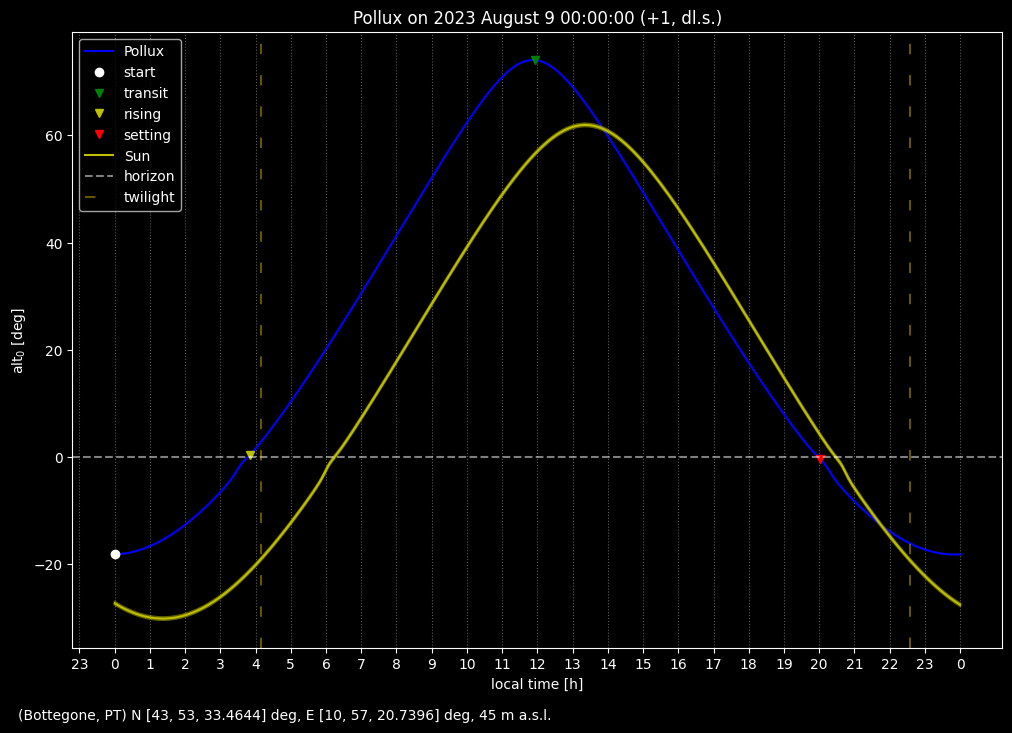

In [149]:
timezone, dl_save = 1, True
date = Date([2023,8,9],timezone=timezone,dl_save=dl_save)
print(date.ut_to_local(timezone,dl_save,'str'))

alt, dayrange = trajectory(date,obs,obj,numpoint) 
# computing the time of the events
m = tran_ris_set(date,obs,obj,True)
event = Date(date.date,m)
# computing the corresponding apparent altitude
ealt = compute_alt(event,obs,obj,True)

dates = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar)
ra, dec = SUN.corr_coor(dates)
lon = obs.lon
lat = obs.lat
lst = local_ST(dates,lon,True)
lha = lst - ra
altaz = equat_to_altaz(Equatorial(ra,dec),lha,lat)
sunrad = SUN.ang_diameter(dates)/2
sunalt = altaz.alt + refraction_corr(altaz.alt,obs.h)
suntw = SUN.twilight(date,obs)
suntw = Date(date.date,suntw,calendar=date.calendar)



## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)
if out[:5] == 'local':
    hzone = timezone
    if dl_save: hzone += 1
elif out == 'UT':
    hzon = 0

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
titledate = date.print_date() if out == 'UT' else date.ut_to_local(timezone,dl_save,'str')
plt.title(obj.name + ' on ' + titledate)
plt.plot(dayrange,alt.deg,'b',label=obj.name)
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')
if type(m.val) != np.ndarray:
    plt.plot(event.jd,ealt.deg,'vg',label='transit')
else:
    plt.plot(event.jd[0],ealt.deg[0],'vg',label='transit')
    plt.plot(event.jd[1],ealt.deg[1],'vy',label='rising')
    plt.plot(event.jd[2],ealt.deg[2],'vr',label='setting')

plt.plot(dayrange,sunalt.deg,'y',label='Sun')
plt.plot(dayrange,sunalt.deg - sunrad.deg,'y',alpha=0.5)
plt.plot(dayrange,sunalt.deg + sunrad.deg,'y',alpha=0.5)
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)
labelticks = np.round(ticks.time.hour() + hzone,0).astype(int)
labelticks = np.where(labelticks >= 24, labelticks-24, labelticks)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.axvline(suntw.jd[0],ymin=0,ymax=1,linestyle=(0,(5,10)),alpha=0.4,color='gold',label='twilight')
plt.axvline(suntw.jd[1],ymin=0,ymax=1,linestyle=(0,(5,10)),alpha=0.4,color='gold')
plt.xticks(ticks.jd,labelticks)
plt.xlabel(out + ' [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)
location_string = obs.place_info(True)
plt.text(0.08, 0.02, location_string, fontsize=10, transform=plt.gcf().transFigure)
plt.show()


plt.show()


## <a id='toc1_5_'></a>[V Moon](#toc0_)


In [173]:
class Moon():
    @staticmethod
    def sun_mean_anom(date: Date) -> Angles:
        date = date.copy().change_time_type('TD')
        T = (date.jd - Date.J2000) / 36525
        M = Angles(357.5291092,'deg') + 35999.052909*T - 1.536e-4*(T**2) + (T**3)/2449e4
        if type(M.deg) == np.ndarray:
            M = M - np.where(M > 360, 360*(M.deg//360), 0).astype(float)
            M = M + np.where(M < 0, 360, 0).astype(float)
        else:
            if abs(M) > 360: M = M % 360
            if M < 0: M = M + 360
        return M

    def __init__(self) -> None:
        self.L = Angles(218.3164477,'deg')
        self.D = Angles(297.8501921,'deg')
        self.M = Angles(134.9633964,'deg')
        self.F = Angles( 93.272095,'deg')
        self.epoch = 'J2000'
        self.dist = 385000.56

    def mean_in_date(self, date: Date, sel: str = 'all') -> list[Angles] | Angles:
        results = []
        date = date.copy().change_time_type('TD')
        T = (date.jd - Date.J2000) / 36525
        if ('L' in sel) or (sel == 'all'):
            L = self.L + 481267.88123421*T - 1.5786e-3*(T**2) + (T**3)/538841 - (T**4)/65194e3
            if type(L.deg) == np.ndarray:
                L = L - np.where(L > 360, 360*(L.deg//360), 0).astype(float)
                L = L + np.where(L < 0, 360, 0).astype(float)
            else:
                if abs(L) > 360: L = L % 360
                if L < 0: L = L + 360
            results += [L]
        if ('D' in sel) or (sel == 'all'):
            D = self.D + 445267.1114034*T  - 1.8819e-3*(T**2) + (T**3)/545868 - (T**4)/113065e3
            if type(D.deg) == np.ndarray:
                D = D - np.where(D > 360, 360*(D.deg//360), 0).astype(float)
                D = D + np.where(D < 0, 360, 0).astype(float)
            else:
                if abs(D) > 360: D = D % 360
                if D < 0: D = D + 360
            results += [D]
        if ('M' in sel) or (sel == 'all'):
            M = self.M + 477198.8675055*T  - 8.7414e-3*(T**2) + (T**3)/69699  - (T**4)/14712e3
            if type(M.deg) == np.ndarray:
                M = M - np.where(M > 360, 360*(M.deg//360), 0).astype(float)
                M = M + np.where(M < 0, 360, 0).astype(float)
            else:
                if abs(M) > 360: M = M % 360
                if M < 0: M = M + 360
            results += [M]
        if ('F' in sel) or (sel == 'all'):
            F = self.F + 483202.0175233*T  - 3.6539e-3*(T**2) - (T**3)/3526e3 + (T**4)/86331e4
            if type(F.deg) == np.ndarray:
                F = F - np.where(F > 360, 360*(F.deg//360), 0).astype(float)
                F = F + np.where(F < 0, 360, 0).astype(float)
            else:
                if abs(F) > 360: F = F % 360
                if F < 0: F = F + 360
            results += [F]
        if len(results) == 1: results = results[0]
        elif len(results) == 0: raise Exception(f'Error in selction!\n`{sel}` is not allowed')
        return results
    
    def get_coor(self, date: Date, sel: str = 'all') -> list[Angles | float | np.ndarray] | Angles | float | np.ndarray:
        results = []
        date = date.copy().change_time_type('TD')
        # print('JD',date.jd)
        T = (date.jd - Date.J2000) / 36525
        # print('T',T)
        L,D,M,F = self.mean_in_date(date)
        Msun = Moon.sun_mean_anom(date)
        E = 1 - 2.516e-3*T - 7.4e-6*(T**2)
        # print("L'",L.deg)
        # print("D",D.deg)
        # print("M",Msun.deg)
        # print("M'",M.deg)
        # print("F",F.deg)
        # print('E',E)
        A1 = 119.75 + 131.849*T
        if type(A1) == np.ndarray:
            A1 = np.where(abs(A1) > 360, A1 % 360, A1)
            A1 = np.where(A1 < 0, A1 + 360, A1)
        else:
            if abs(A1) > 360: A1 %= 360
            if A1 < 0: A1 += 360 
        # print('A1',A1)
        A1 = Angles.deg_to_rad(A1)

        L = L.rad
        D = D.rad
        M = M.rad
        F = F.rad
        Msun = Msun.rad

        if type(T) != np.ndarray:
            T = np.array([T])
            L = np.array([L])
            D = np.array([D])
            M = np.array([M])
            F = np.array([F])
            Msun = np.array([Msun])
            E = np.array([E])
            A1 = np.array([A1])

        alon = np.array([])
        alat = np.array([])
        adist = np.array([])
        
        if ('lon' in sel) or ('dist' in sel) or (sel == 'all'):
            cd1,cmsun1,cm1,cf1,lon1,dist1 = get_data('moon1_data.csv')
        if ('lat' in sel) or (sel == 'all'):
            cd2,cmsun2,cm2,cf2,lat2 = get_data('moon2_data.csv')
        
        for (t,l,d,m,f,msun,e,a1) in zip(T,L,D,M,F,Msun,E,A1):
            if ('lon' in sel) or (sel == 'all'):        
                A2 = 53.09 + 479264.29*t
                if abs(A2) > 360: A2 %= 360
                if A2 < 0: A2 += 360 
                # print('A2',A2)
                A2 = Angles.deg_to_rad(A2)
                
                lon = lon1*np.sin(cd1*d + cmsun1*msun + cm1*m + cf1*f)
                lon *= np.where(abs(cmsun1)==1,e,1)*np.where(abs(cmsun1)==2,e**2,1)
                lon = lon.sum()
                lon += 3958*np.sin(a1) + 1962*np.sin(l-f) + 318*np.sin(A2)
                # print('Sl',lon)

                lon = Angles.rad_to_deg(l) + lon*1e-6
                alon = np.append(alon,lon)

            if ('dist' in sel) or (sel == 'all'):
                dist = dist1*np.cos(cd1*d + cmsun1*msun + cm1*m + cf1*f)
                dist *= np.where(abs(cmsun1)==1,e,1)*np.where(abs(cmsun1)==2,e**2,1)
                dist = dist.sum()
                # print('Sr',dist)

                dist = self.dist + dist*1e-3
                adist = np.append(adist,dist)


            if ('lat' in sel) or (sel == 'all'):
                A3 = 313.45 + 481266.484*t
                if abs(A3) > 360: A3 %= 360
                if A3 < 0: A3 += 360 
                # print('A3',A3)
                A3 = Angles.deg_to_rad(A3)
                
                lat = lat2*np.sin(cd2*d + cmsun2*msun + cm2*m + cf2*f)
                lat *= np.where(abs(cmsun2)==1,e,1)*np.where(abs(cmsun2)==2,e**2,1)
                lat = lat.sum()
                lat += -2235*np.sin(l) + 382*np.sin(A3) + 350*np.sin(a1)*np.cos(f)+127*np.sin(l-m)-115*np.sin(l+m)
                # print('Sb',lat)

                lat *= 1e-6
                alat = np.append(alat,lat)
        
        if ('lon' in sel) or (sel == 'all'): 
            if len(T) == 1:
                alon = alon[0]
            results += [Angles(alon,'deg')]
        if ('lat' in sel) or (sel == 'all'): 
            if len(T) == 1:
                alat = alat[0]
            results += [Angles(alat,'deg')]
        if ('dist' in sel) or (sel == 'all'): 
            if len(T) == 1:
                adist = adist[0]
            results += [adist]
        if len(results) == 1: results = results[0]
        elif len(results) == 0: raise Exception(f'Error in selection!\n`{sel}` is not allowed')

        return results 

    def equat_coor(self,date: Date, sel: str = 'all', app_val: bool = True) -> HAngles | Angles | tuple[HAngles,Angles]:
        e = mean_obliquity(date)
        lon, lat = self.get_coor(date,'lonlat')
        if app_val:
            Dlon, De = nutation_corr(date)
            lon = lon + Dlon
            e = e + De
        coor = eclipt_to_equat(Ecliptical(lon,lat),e)
        # Dra, Ddec = Angles(0,'deg'),Angles(0,'deg')
        Dra, Ddec = SUN.aberration_corr(date,coor)
        if   sel == 'ra' : return coor.alpha + Dra
        elif sel == 'dec': return coor.delta + Ddec
        elif sel == 'all': return coor.alpha + Dra, coor.delta + Ddec
        else: raise Exception(f'Error in selection!\n`{sel}` is not allowed')

    def parallax(self, date: Date) -> Angles:
        dist = self.get_coor(date,sel='dist')
        para = np.arcsin(6378.14/dist)
        return Angles(para,'rad')

    def ang_diameter(self, date: Date, alt: Angles) -> Angles:
        dist = self.get_coor(date,'dist')
        para = self.parallax(date)
        s = 716946800/dist * (1+np.sin(alt.rad)*np.sin(para.rad))
        return Angles(s/3600,'deg')

    def rise_set(self, date: Date, obs_pos: GeoPos, results: bool = True, iter: int = 3) -> Time | None:
        date = date.copy()
        lon = obs_pos.lon
        lat = obs_pos.lat
        height = obs_pos.h
        # computing the GST for the meridian in date at 0h UT
        tmpdate = Date(date.date,0.)
        Dt = time_correction(tmpdate.date[0])
        GST0 = Green_ST(tmpdate,True)
        # computing r.a. and dec. on nearest days
        # (previous and consecutive one) at 0h TD     
        tmpdate = Date(date.date,0.,timetype='TD')
        jd = tmpdate.jd
        a1, d1 = self.equat_coor(tmpdate-1)
        a2, d2 = self.equat_coor(tmpdate)
        a3, d3 = self.equat_coor(tmpdate+1)
        h0 = refraction_corr(Angles(0.,'deg',lim=90),height, alt0=True) + 0.7275*self.parallax(tmpdate)
        del tmpdate
        # transit computation in decimals of a day
        mt = (a2 + lon - GST0).deg / 360 
        # checking the value       
        if abs(mt) > 1:
            mt -= np.sign(mt)
        elif mt < 0:
            mt += 1
        # rising and setting
        # true altitude for a zero apparent altitude  
        # computing approximated value for HA
        cosH0 = (np.sin(h0.rad) - np.sin(lat.rad)*np.sin(d2.rad)) / (np.cos(lat.rad)*np.cos(d2.rad))
        # checking the presence of rising and setting
        if abs(cosH0) <= 1:
            H0 = HAngles(np.arccos(cosH0),'rad',lim=180)
            # time of rising and setting in decimals of a day
            mr = mt - H0.deg/360
            ms = mt + H0.deg/360
            # generalizing the method 
            m = np.array([mr,ms])
            # checking the value       
            m = np.where(abs(m) > 1, m-np.sign(m), m)
            m = np.where(m < 0, m+1, m)
            # routine
            for k in range(iter):
                # computing the corresponding GST
                GST = GST0.deg + 360.985647*m
                # checking the value       
                GST = np.where(GST > 360, GST - 360*(GST/360).astype(int), GST)               
                GST = HAngles(GST,'deg')
                # converting from TD to UT
                n = m + Dt/Time.DAYSEC
                # computing the corresponging r.a.
                a = np.array([interpole_three([a1.deg,a2.deg,a3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                a = HAngles(a,'deg')
                # computing the corresponging dec.
                d = np.array([interpole_three([d1.deg,d2.deg,d3.deg],ni+jd,[jd-1,jd,jd+1]) for ni in n])
                d = HAngles(d,'deg',lim=90) 
                # computing the HA
                H = GST - lon - a
                # computing corresponding altitude
                h = np.arcsin(np.sin(lat.rad)*np.sin(d.rad) + np.cos(lat.rad)*np.cos(d.rad)*np.cos(H.rad))
                h = Angles(h,'rad',lim=90)
                # correcting the previous computation
                Dm = (h-h0).deg / (360 * (np.cos(d.rad)*np.cos(lat.rad)*np.sin(H.rad)))
                m += Dm
                # checking the value       
                m = np.where(abs(m) > 1, m-np.sign(m), m)
                m = np.where(m < 0, m+1, m)
            
            time = date.time
            # checking the value       
            m = np.where(m*24 < time.hour(), m+1, m)
            m = Time(m*Time.DAYSEC)    
            # condition to print the results
            if results:
                mr, ms = m.val
                rising  = Date(date.date,Time(mr),calendar=date.calendar)
                setting = Date(date.date,Time(ms),calendar=date.calendar)

                event = [rising,setting]
                names = ['rising ','setting']
                for i in range(2):
                    print(names[i] + ':\t' + event[i].print_date() + ' ==> ' + event[i].ut_to_local(timezone,dl_save,'str'))
            return m
        else:
            if results:
                res_str = 'rises' if cosH0 > 0 else 'sets'
                print('Moon never ' + res_str)
            return None
    
    def ill_fract(self, date: Date, sunlon: Angles, sundist: float | np.ndarray) -> float | np.ndarray:
        lon, lat, dist = self.get_coor(date)
        Dlon, _ = nutation_corr(date)
        lon = lon + Dlon
        geo_el = np.arccos(np.cos(lat.rad)*np.cos(lon.rad-sunlon.rad))
        i = np.arctan2(sundist*np.sin(geo_el),dist-sundist*np.cos(geo_el))
        return (1 + np.cos(i))/2

    def moon_phase():
        return


MOON = Moon()
date = Date([1992,4,12],timetype='TD')
lon,lat,d = MOON.get_coor(date)
para = MOON.parallax(date)
print('lon',lon.print_angle('deg'))
print('lat',lat.print_angle('deg'))
print('d',d)
print('pi',para.print_angle('deg'))



lon +[133, 9, 45.5050]
lat -[3, 13, 44.8516]
d 368409.67905553844
pi +[0, 59, 31.1644]


2023 August 11 13:05:00 (+1, dl.s.)

transit:	2023 August 12 09:44:28.4657 UT ==> 2023 August 12 11:44:28.4657 (+1, dl.s.)
rising :	2023 August 12 01:38:42.3477 UT ==> 2023 August 12 03:38:42.3477 (+1, dl.s.)
setting:	2023 August 11 17:50:14.5814 UT ==> 2023 August 11 19:50:14.5814 (+1, dl.s.)
sun az -[8, 14, 1.3453]

!warning: you are subtracting angles with different limits: 90 and 360!
The limit of the sum is taken equal to that of ang1

rising :	2023 August 12 04:15:11.3549 UT ==> 2023 August 12 06:15:11.3549 (+1, dl.s.)
setting:	2023 August 11 18:26:53.4267 UT ==> 2023 August 11 20:26:53.4267 (+1, dl.s.)

!warning: you are summing angles with different limits: 360 and 90!
The limit of the sum is taken equal to that of ang1

Twilight -> 2.013 h
morning:	2023 August 12 02:14:25.9131 UT ==> 2023 August 12 04:14:25.9131 (+1, dl.s.)
evening:	2023 August 11 20:27:38.8685 UT ==> 2023 August 11 22:27:38.8685 (+1, dl.s.)
moon az +[87, 25, 54.1031]

!warning: you are summing angles with dif

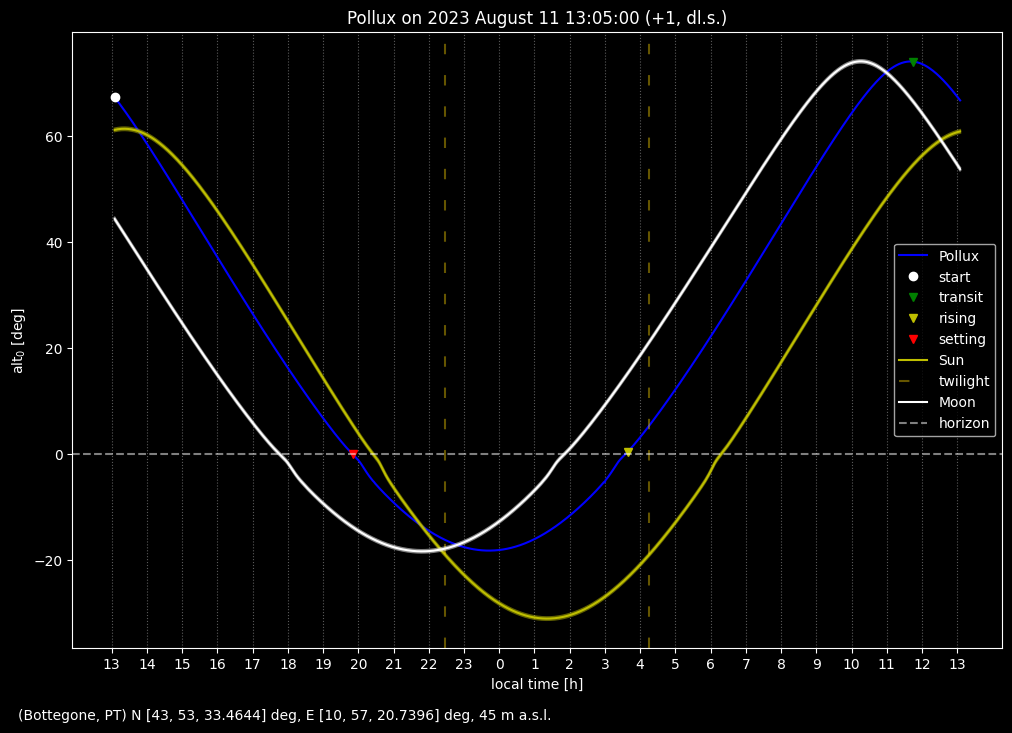

Illuminated fraction of Moon disk: 21.169360961090888 %


In [174]:
timezone, dl_save = 1, True
date = Date([2023,8,11],[13,5,0],timezone=timezone,dl_save=dl_save)
print(date.ut_to_local(timezone,dl_save,'str'))

alt, dayrange = trajectory(date,obs,obj,numpoint) 

# computing the time of the events
m = tran_ris_set(date,obs,obj,True)
event = Date(date.date,m)
# computing the corresponding apparent altitude
ealt = compute_alt(event,obs,obj,True)

dates = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar)
ra, dec = SUN.corr_coor(dates)
lon = obs.lon
lat = obs.lat
lst = local_ST(dates,lon,True)
lha = lst - ra
altaz = equat_to_altaz(Equatorial(ra,dec),lha,lat)
print('sun az',altaz.az.print_angle('deg')[0])
sunrad = SUN.ang_diameter(dates)/2
sunalt = altaz.alt + refraction_corr(altaz.alt,obs.h)
suntw = SUN.twilight(date,obs)
suntw = Date(date.date,suntw,calendar=date.calendar)

dates = Date(jd=dayrange,timetype=date.time.tytime,calendar=date.calendar)
ra, dec = MOON.equat_coor(dates)
lst = local_ST(dates,lon,True)
lha = lst - ra
altaz = equat_to_altaz(Equatorial(ra,dec),lha,lat)
print('moon az',altaz.az.print_angle('deg')[0])
moonrad = MOON.ang_diameter(dates, altaz.alt)/2
moonalt = altaz.alt + refraction_corr(altaz.alt,obs.h)
moonrs = MOON.rise_set(date,obs)

## PLOT ##
hour = date.time.hour() 
N = 25 if hour <= (int(hour)+0.5) else 26
ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)
if out[:5] == 'local':
    hzone = timezone
    if dl_save: hzone += 1
elif out == 'UT':
    hzon = 0

plt.figure(figsize=[12,8])
ax = plt.axes()
ax.set_facecolor('black')
titledate = date.print_date() if out == 'UT' else date.ut_to_local(timezone,dl_save,'str')
plt.title(obj.name + ' on ' + titledate)

plt.plot(dayrange,alt.deg,'b',label=obj.name)
plt.plot(dayrange[0],alt.deg[0],'ow',label='start')
if type(m.val) != np.ndarray:
    plt.plot(event.jd,ealt.deg,'vg',label='transit')
else:
    plt.plot(event.jd[0],ealt.deg[0],'vg',label='transit')
    plt.plot(event.jd[1],ealt.deg[1],'vy',label='rising')
    plt.plot(event.jd[2],ealt.deg[2],'vr',label='setting')

plt.plot(dayrange,sunalt.deg,'y',label='Sun')
plt.plot(dayrange,sunalt.deg - sunrad.deg,'y',alpha=0.5)
plt.plot(dayrange,sunalt.deg + sunrad.deg,'y',alpha=0.5)
plt.axvline(suntw.jd[0],ymin=0,ymax=1,linestyle=(0,(5,10)),alpha=0.4,color='gold',label='twilight')
plt.axvline(suntw.jd[1],ymin=0,ymax=1,linestyle=(0,(5,10)),alpha=0.4,color='gold')

plt.plot(dayrange,moonalt.deg,'w',label='Moon')
plt.plot(dayrange,moonalt.deg - moonrad.deg,'w',alpha=0.5)
plt.plot(dayrange,moonalt.deg + moonrad.deg,'w',alpha=0.5)

ticks = Date(date.date, (np.arange(0,N,1)+int(date.time.hour()))*3600,calendar=date.calendar)
labelticks = np.round(ticks.time.hour() + hzone,0).astype(int)
labelticks = np.where(labelticks >= 24, labelticks-24, labelticks)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,color='white',label='horizon')
plt.xticks(ticks.jd,labelticks)
plt.xlabel(out + ' [h]')
plt.ylabel('alt$_0$ [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)
plt.legend(numpoints=1)
location_string = obs.place_info(True)
plt.text(0.08, 0.02, location_string, fontsize=10, transform=plt.gcf().transFigure)
plt.show()


plt.show()

print(f'Illuminated fraction of Moon disk: {MOON.ill_fract(date,SUN.app_lon(date),SUN.distance(date)*SUN.AU)*100} %')


## <a id='toc1_6_'></a>[VI Studying the visibility](#toc0_)

### <a id='toc1_6_1_'></a>[VI.I Angular separation](#toc0_)